Things To Do:
- Take in CollectionState.json versus compiled version from jjerot
- make sheet of own collection

In [1]:
import numpy as np
import math
import scipy
import scipy.stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import classes
import glob

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'axes.labelsize': 16})
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

# for quick exits
class StopExecution(Exception):
    def _render_traceback_(self):
        return []



In [2]:
def estimate_hdi(posterior, interval_width=0.95):
    # simply find the values that contain 0.95 of the posterior
    norm = posterior/np.sum(posterior)
    low = (1 - interval_width)/2
    high = interval_width + (1 - interval_width)/2
    high_arg = np.argmin(np.abs(np.cumsum(norm)-high))
    low_arg = np.argmin(np.abs(np.cumsum(norm)-low))
    return low_arg, high_arg

def estimate_uncertainty(p_grid, posterior, interval_width=0.95):
    low_arg, high_arg = estimate_hdi(posterior, interval_width=interval_width)
    pos_max = p_grid[posterior.argmax()]
    pos_low = p_grid[low_arg]
    pos_high = p_grid[high_arg]
    #simply find the uncertainty
    low_bound = pos_max - pos_low
    high_bound = pos_high - pos_max
    return low_arg, high_arg, pos_low, pos_high, low_bound, high_bound

def cull_splits(subset, n_cull):
    # remove the earliest n_cull splits
    #CHECK THIS
    tempset = subset.sort_values('time')[:n_cull]
    #count the number of ink and gold that were nixed
    n_ink_cull = len(tempset[tempset['back']=='Ink'])
    n_gold_cull = len(tempset[tempset['back']=='GoldFoil'])
    n_foil_cull = len(tempset[tempset['back']=='Foil'])
    n_prism_cull = len(tempset[tempset['back']=='PrismFoil'])
    return subset.sort_values('time')[n_cull:], n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull

def random_cull_splits(subset, n_cull=3):
    #old method now deprecated that we load in time info
    # we need to remove the first split and remove N random earlier ones
    subset = subset[subset['effect']==subset['effect']]
    # if we only want to cull 3
    inkfilter = subset['back'].str.contains('Ink')
    goldfilter = subset['back'].str.contains('Gold')
    kirbyfilter = subset['effect'].str.contains('Kirby')

    drop_filter = ~inkfilter & ~goldfilter & ~kirbyfilter
    drop_indices = np.random.choice(subset[drop_filter].index, n_cull-1, replace=False)
    df_subset = subset.drop(drop_indices)

    return df_subset


As we do this more and more, we should expect to see our posterior distributions move towards the most likely value of $p$. 

Now, we do this for an entire collection of cards. We will do this with data from jjerot. We will do this for Ink, Gold, and Krackle (all independently), as well as look at probabilities for Ink+Krackle and Gold+Krackle. 

In [3]:
#from pyparsing import col
import classes.collection
# run to save files


file_list = glob.glob('./data/CollectionState*.json')
print(file_list)
collection_list = []

ignore = ['jjerot', 'maqij','rising_rider','nopo']

for filename in file_list:
    print(filename,' ', filename.split('.')[-2])
    if filename.split('.')[-2] in ignore:
        print('Ignoring ', filename)
        continue
    temp_coll = classes.collection.Collection(path='',filename=filename)
    print('Input:', filename.split('/')[-1])
    #collection_list.append(temp_coll.split_info)


#type(collection_list[0][0])
#df = pd.DataFrame(collection_list[0],columns=['name','back','effect','time'])
#collections = []
#for collection in collection_list:
#    collections.append(pd.DataFrame.from_dict(collection,columns=['name','back','effect','time']))

['./data/CollectionState.maqij.json', './data/CollectionState.rising_rider.json', './data/CollectionState.LaurenWhatevs.json', './data/CollectionState.nopo.json', './data/CollectionState.jjerot.json']
./data/CollectionState.maqij.json   maqij
Ignoring  ./data/CollectionState.maqij.json
./data/CollectionState.rising_rider.json   rising_rider
Ignoring  ./data/CollectionState.rising_rider.json
./data/CollectionState.LaurenWhatevs.json   LaurenWhatevs
./data/CollectionState.LaurenWhatevs.json
Input: CollectionState.LaurenWhatevs.json
./data/CollectionState.nopo.json   nopo
Ignoring  ./data/CollectionState.nopo.json
./data/CollectionState.jjerot.json   jjerot
Ignoring  ./data/CollectionState.jjerot.json


[ 0. 36.  3.  4.  6.  8.  3.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[  0. 157.  41.  20.  12.  14.   9.   3.   2.   4.   2.   1.   2.   0.
   2.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.]
[  0. 257.  89.  46.  23.  26.  11.   5.   3.   5.   2.   1.   2.   0.
   2.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.]
[  0. 308.  94.  46.  36.  32.  22.  22.  10.  11.   8.   7.   4.   4.
   2.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.]
[  0. 338. 101.  63.  46.  42.  30.  30.  14.  17.  11.   7.   6.   6.
   3.   0.   0.   0.   2.   3.   0.   0.   0.   0.   0.

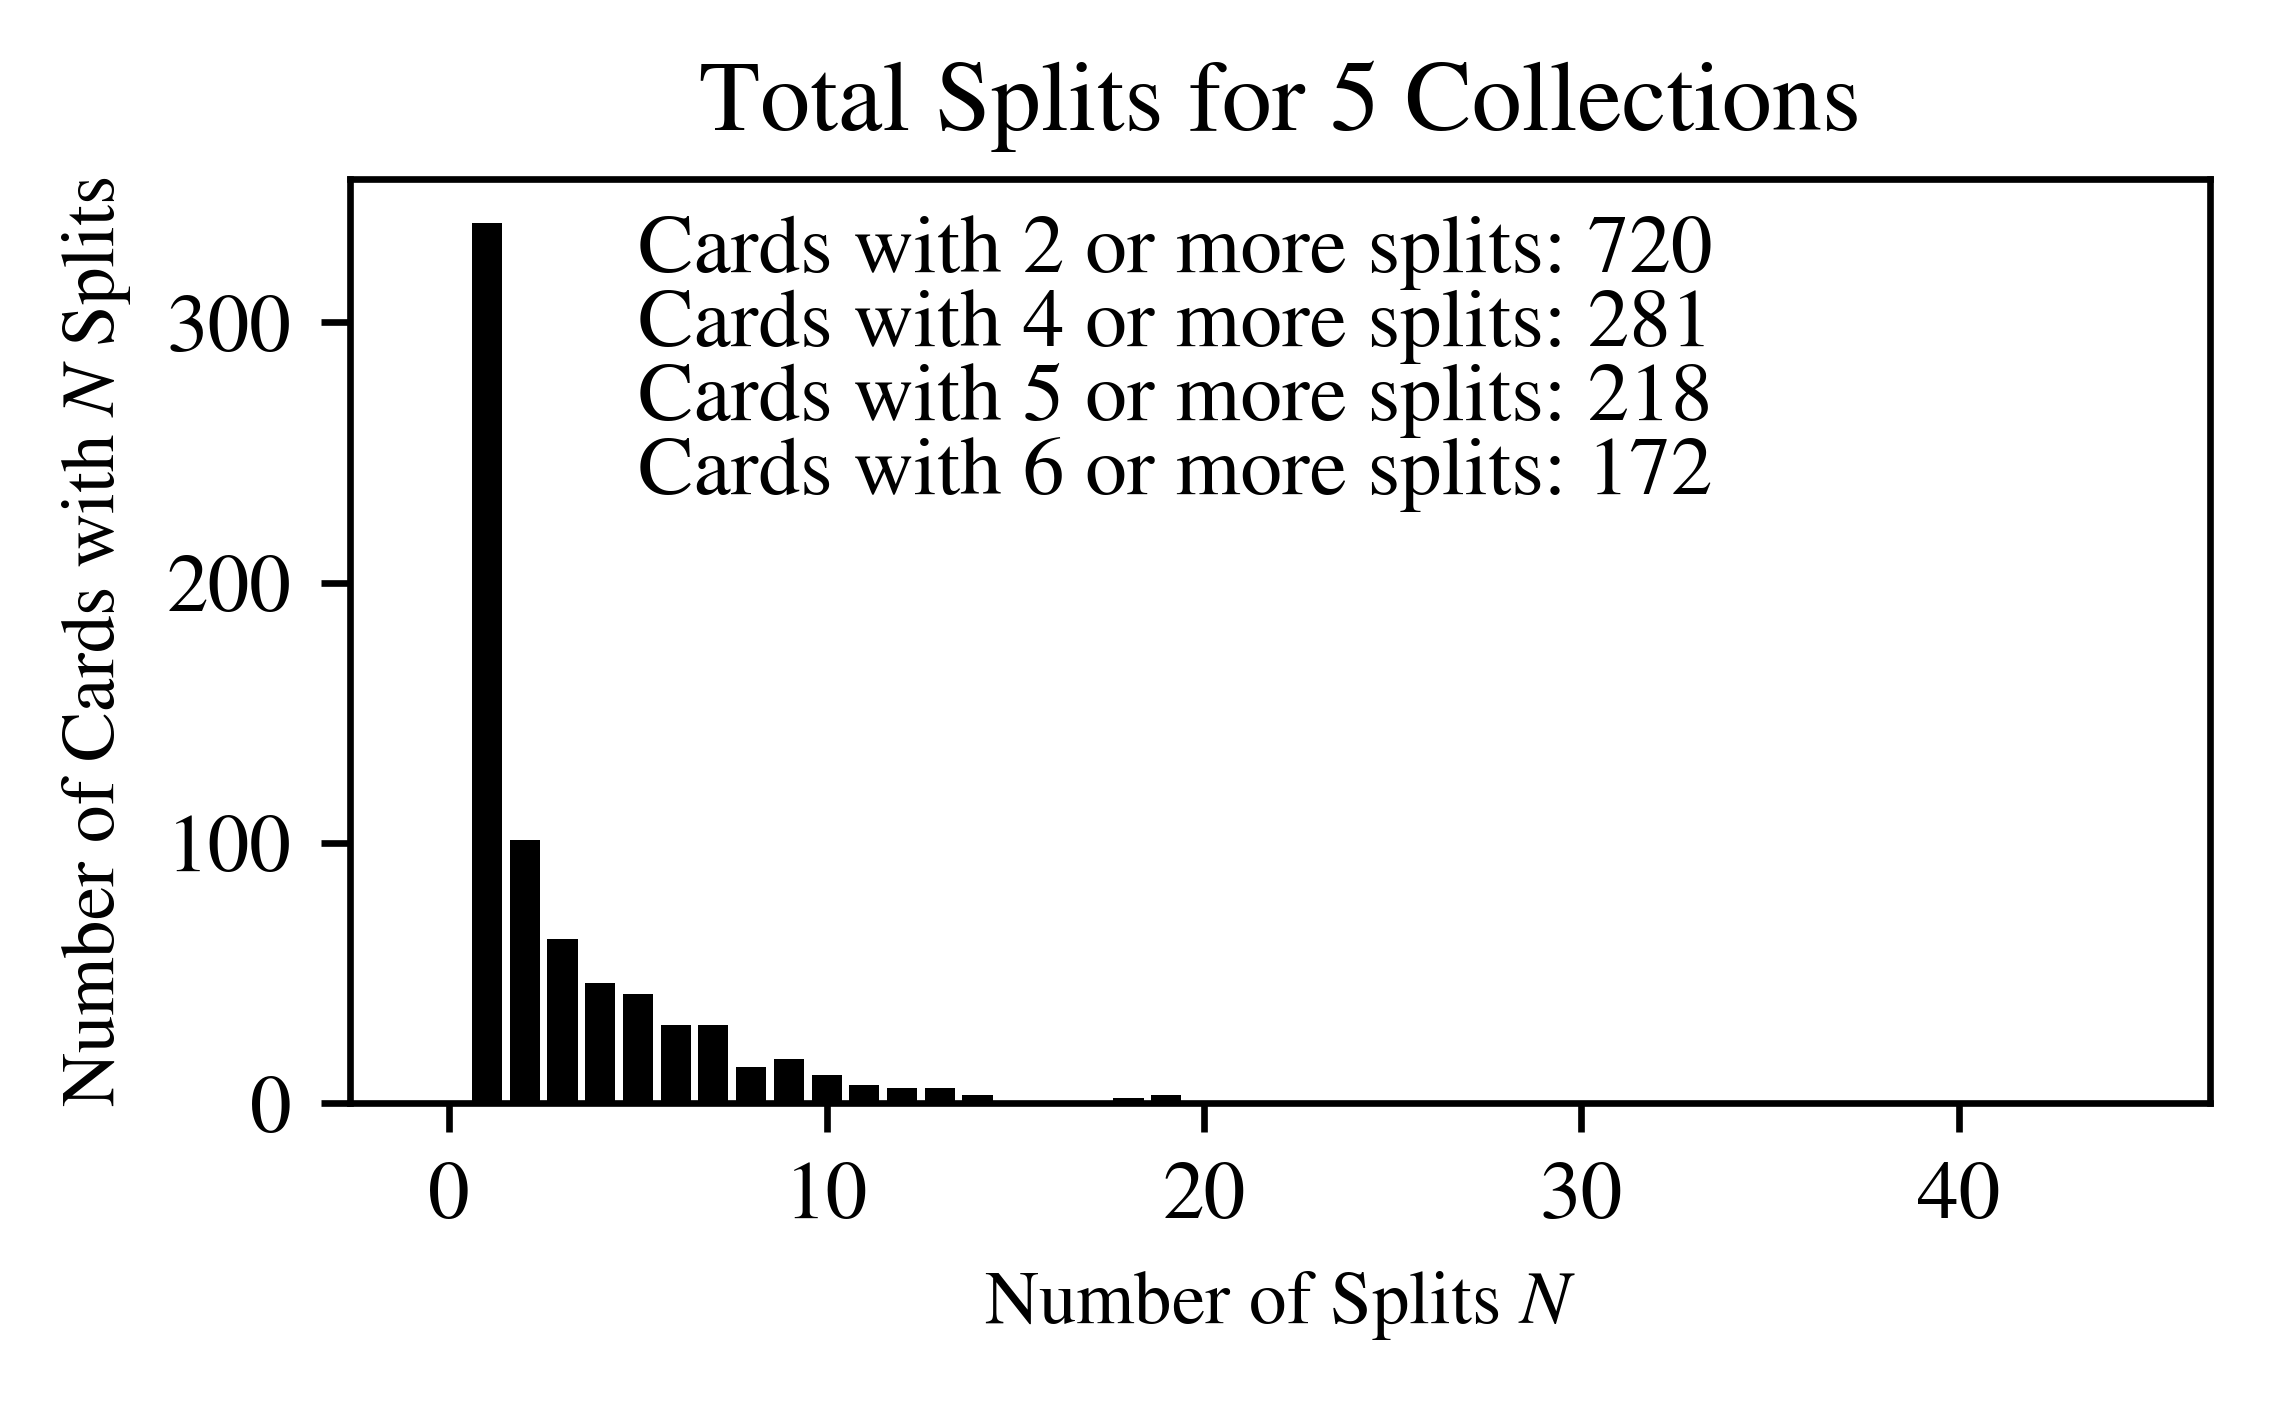

In [4]:
file_list = glob.glob('./data/newSplitData.*.txt')
collection_list = []
collection_names = []

for filename in file_list:
    collection_names.append(filename.split('.')[-2])
    all_cards_master = pd.read_csv(filename, delimiter=' ',header=0,names=['name','back','effect','time'])
    all_cards_master['time'] = pd.to_datetime(all_cards_master['time'],format='%Y-%m-%dT%H:%M:%S.%fZ')
    all_cards_master = all_cards_master.fillna('None')
    collection_list.append(all_cards_master)

n_bins = 45
n_splits_total = np.zeros(n_bins)

for i in range(len(collection_list)):
    all_cards_master = collection_list[i].copy()
    for name in all_cards_master['name'].unique():
        subset = all_cards_master[all_cards_master['name']==name]
        n_splits = len(subset)
        n_splits_total[n_splits] +=1
    print(n_splits_total)

fig,ax = plt.subplots(figsize=(4,2))
ax.set_title(f'Total Splits for {len(collection_list)} Collections')
ax.bar(np.arange(n_bins),n_splits_total,color='k')
y = ax.get_ylim()[1]
ax.text(5,y*.9,f"Cards with 2 or more splits: {int(np.sum(n_splits_total[1:]))}")#,color='C1')
ax.text(5,y*.82,f"Cards with 4 or more splits: {int(np.sum(n_splits_total[3:]))}")
ax.text(5,y*.74,f"Cards with 5 or more splits: {int(np.sum(n_splits_total[4:]))}")
ax.text(5,y*.66,f"Cards with 6 or more splits: {int(np.sum(n_splits_total[5:]))}")
ax.set_xlabel(r'Number of Splits $N$',fontsize=9)
ax.set_ylabel(r'Number of Cards with $N$ Splits',fontsize=9)

for i in range(len(collection_list)):
    all_cards_master = collection_list[i].copy()
    n_ink = 0
    n_gold = 0
    n_kirby = 0
    n_inkkirby = 0
    n_goldkirby = 0
    for name in all_cards_master['name'].unique():

        subset = all_cards_master[all_cards_master['name']==name]
        n_splits = len(subset)
        n_splits_total[n_splits] +=1
        for sub in subset.iterrows():
            # always cummulate backs
            if sub[1]['back']=='Ink':
                n_ink += 1
            if sub[1]['back']=='GoldFoil':
                n_gold += 1
            # cummulate kirbys as well
            if 'Kirby' in sub[1]['effect']:
                n_kirby += 1
                if sub[1]['back']=='Ink':
                    n_inkkirby += 1
                if sub[1]['back']=='GoldFoil':
                    n_goldkirby += 1
    print('Num Ink: ', n_ink)

        

In [5]:
collection_list[0].sort_values('time')

,name,back,effect,time
46,ScarletWitch,PrismFoil,None,2023-10-31 12:52:19.801
31,Medusa,PrismFoil,None,2023-11-01 03:14:48.917
64,IronMan,PrismFoil,None,2023-11-04 07:56:04.362
140,Onslaught,PrismFoil,None,2023-11-09 13:23:20.088
95,Hulkbuster,PrismFoil,None,2023-11-10 03:02:35.736
...,...,...,...,...
73,KittyPryde,PrismFoil,ComicBlue,2024-06-12 03:01:01.390
23,Vision,PrismFoil,GlimmerRed,2024-06-13 01:28:40.376
53,DrDoom,Foil,None,2024-06-14 02:03:35.148
56,DrDoom,PrismFoil,ComicBlue,2024-06-15 06:23:58.863


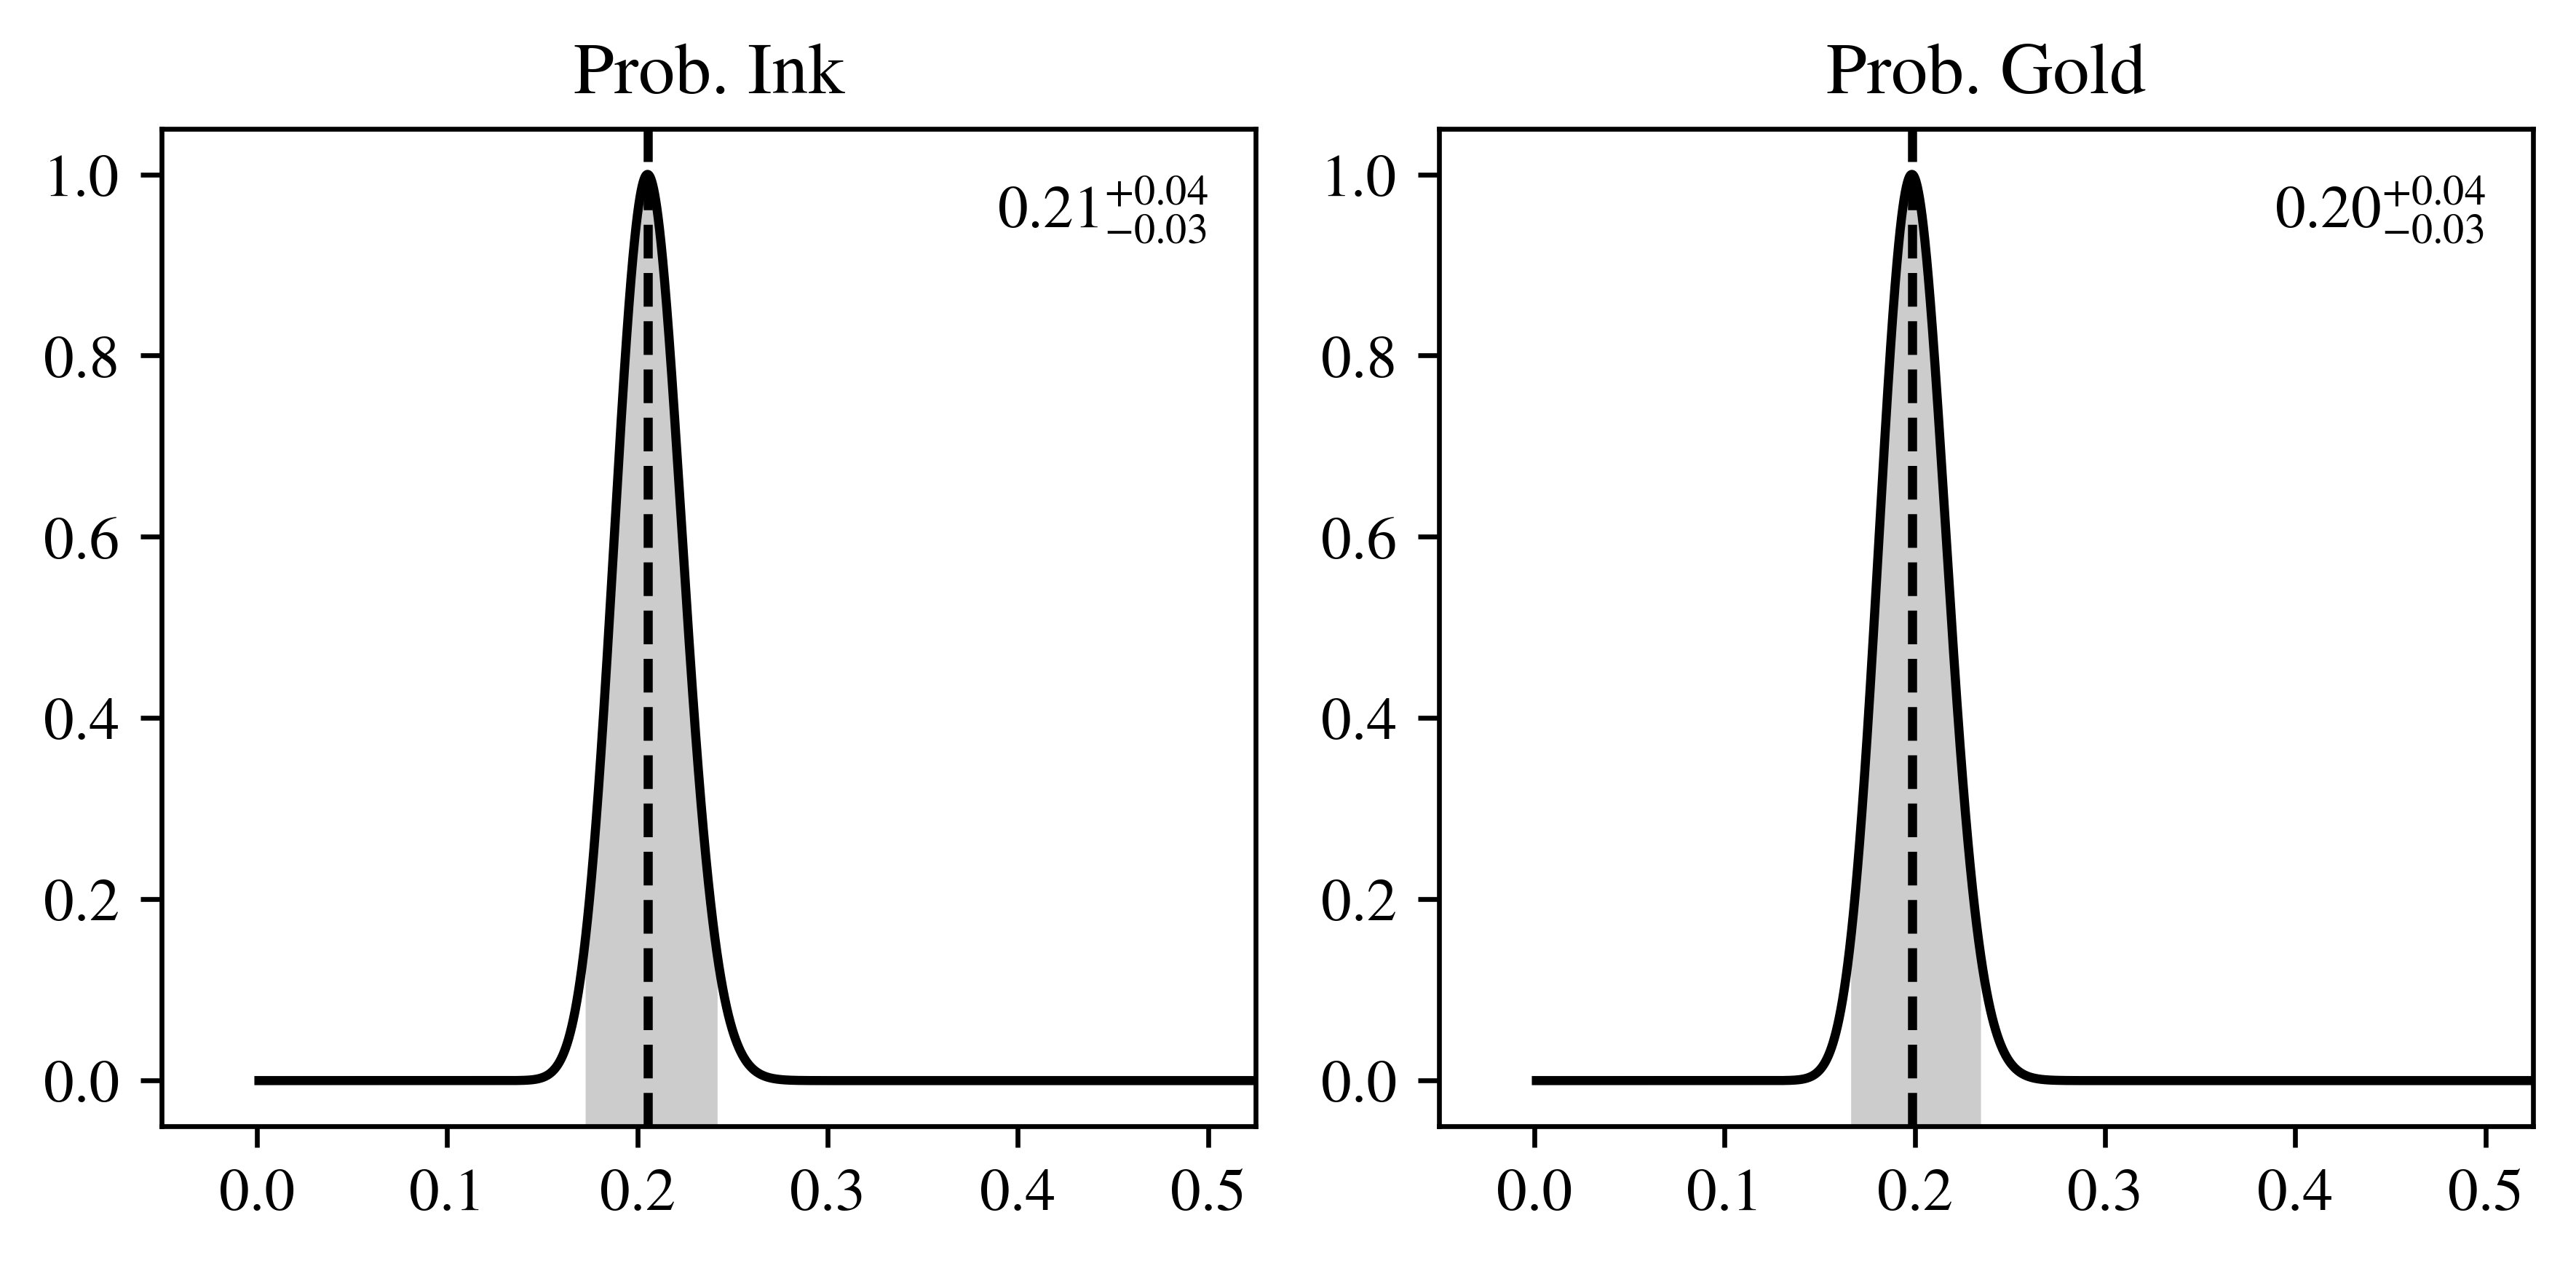

In [6]:
####NEW VERSION###
# What are the "premium" probs on and after sixth split
n_steps = 10000
p_grid = np.linspace(0.001,0.999,n_steps)
gold_prior = np.ones(n_steps)
ink_prior = np.ones(n_steps)
gold_nominal = 0.1
ink_nominal = 0.1
gold_expected = 0.2
expecteds = [gold_expected, ink_nominal]
nominals = [gold_nominal]

# for every colleciton
for collection in collection_list:
    # make a copy for safety
    all_cards = collection.copy()
    # for every card in the collection
    for name in all_cards['name'].unique():
        # make a list of all splits for the card
        subset = all_cards[all_cards['name']==name]
        # get number of splits total
        n_splits_total = len(subset)
        # number of splits to get rid of 
        n_cull = 5
        # if at least one split won't be considered, skip to next
        if n_splits_total < n_cull+1:
            continue
        
        # cull first n splits, and get the number of gold and iked removed
        # last two not used here yet
        subset, n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull = cull_splits(subset, n_cull=n_cull)
        # number of total draws considered
        n_draw = len(subset)
        # a lower limit on number of draws
        # if n_draw < 4:
        #    continue
        # reset counts
        n_gold = 0
        n_ink = 0

        for sub in subset.iterrows():
            # always cummulate backs
            if sub[1]['back']=='GoldFoil':
                n_gold += 1
            if sub[1]['back']=='Ink':
                n_ink += 1

        # number of golds in pool when draw occurs
        n_gold_left = 4*8 - n_gold_cull
        # number of ink left
        n_ink_left = 4*8 - n_ink_cull
        # number of total splits left in pool when draw occurs
        # note n_cull includes the first split which has no effect
        n_total_left = 4*4*8 - (n_cull-1)

        # compute the odds ratio grid
        # lower denom needs to be the number of non-gold splits left, not total
        or_grid = (p_grid/n_gold_left) / ((1-p_grid)/(n_total_left - n_gold_left))

        # print(n_gold,n_total_left,n_gold_left,n_draw)
        gold_likelihood = scipy.stats.nchypergeom_wallenius.pmf(n_gold, n_total_left, n_gold_left, n_draw, or_grid)
        ink_likelihood = scipy.stats.nchypergeom_wallenius.pmf(n_ink, n_total_left, n_ink_left, n_draw, or_grid)
        # gold_likelihood[np.isnan(gold_likelihood)] = 0
        # print(np.max(gold_likelihood * gold_prior))
        gold_posterior = gold_likelihood * gold_prior / np.max(gold_likelihood * gold_prior)
        ink_posterior = ink_likelihood * ink_prior / np.max(ink_likelihood * ink_prior)
        #if len(gold_posterior[np.isnan(gold_posterior)]) > 0:
        #    continue

        gold_prior = gold_posterior
        ink_prior = ink_posterior


#fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 3))
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

text_x = 0.5
text_y = 1
titles = ['Prob. Ink', 'Prob. Gold']
posteriors = [ink_posterior,gold_posterior]

for i in np.arange(len(posteriors)):
    temp_ax = ax.flatten()[i]
    # temp_ax = ax
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--',label='Estimated Gold Prob.')
    # temp_ax.axvline(nominals[i],color='C3',linestyle='--',label='Odds Ratio for 10% Gold')
    # temp_ax.axvline(expecteds[i],color='C0',linestyle='--',label='Odds Ratio for 20% Gold')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i])
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='right')

#ax.set_xlabel('Gold Probability')
#ax.legend(loc=7)
fig.tight_layout()          
# print(gold_posterior)
        

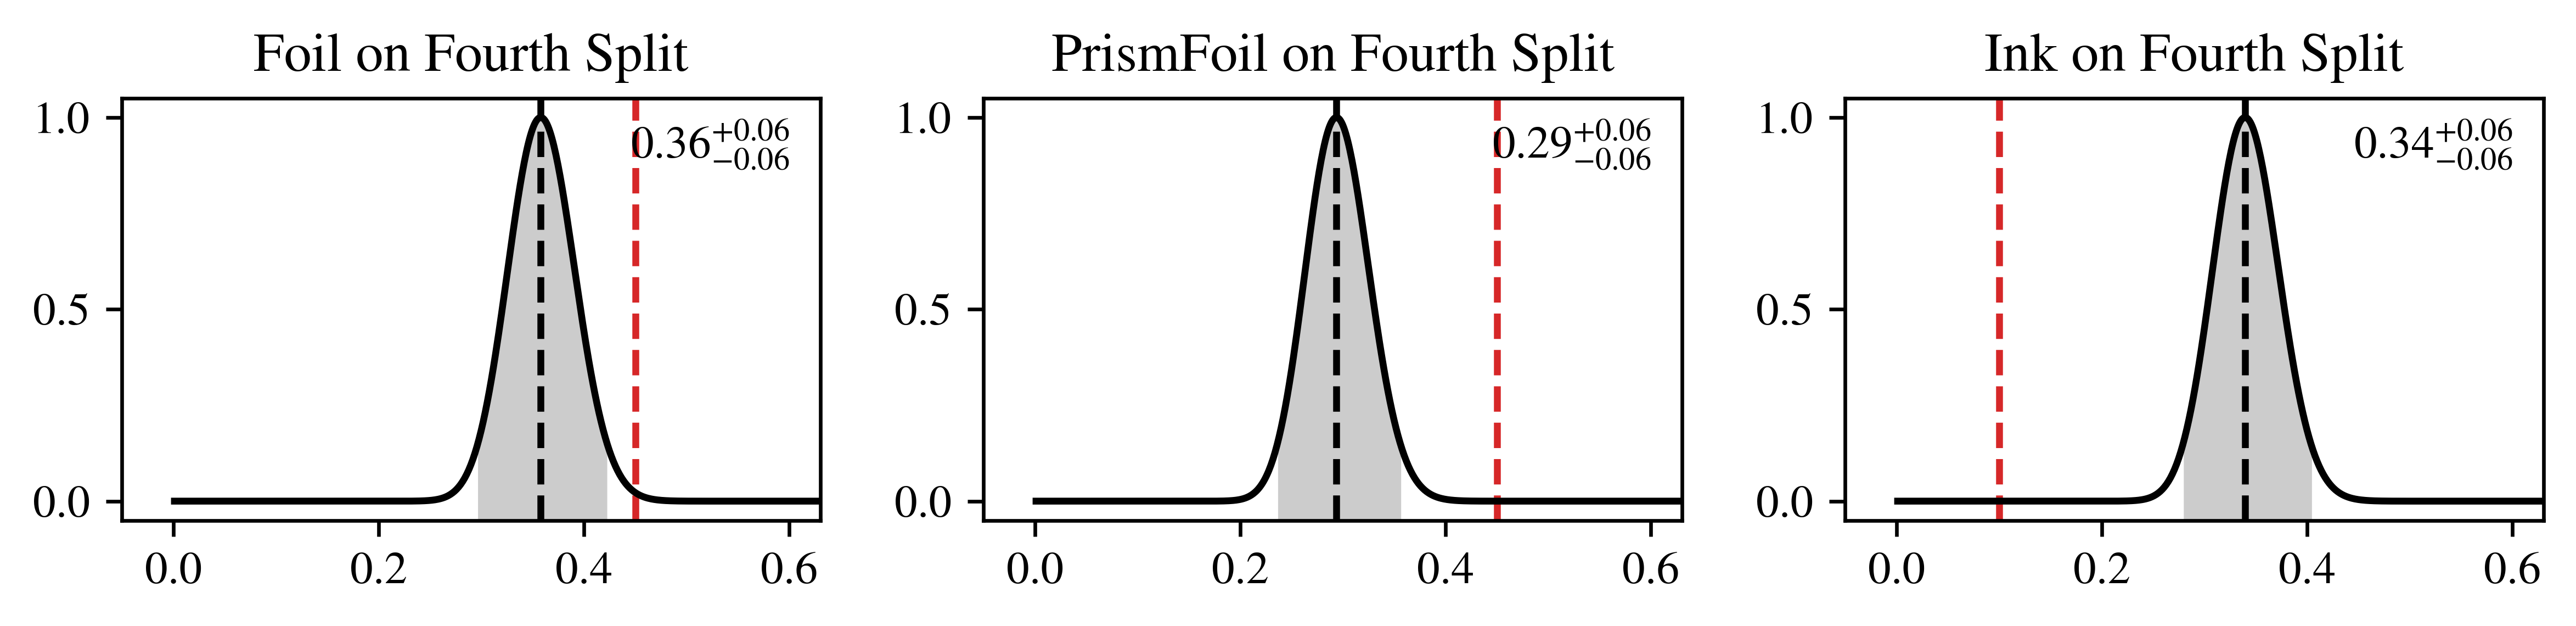

In [7]:
# back probs on fourth split
p_grid = np.linspace(0.001,0.999,1000)
colors = ['Foil', 'PrismFoil', 'Ink']
priors = [np.ones(1000)] * 3
posteriors = [np.ones(1000)] * 3
nominals = [0.45,0.45,0.1]
all_cards = all_cards_master.copy()
n_cull = 3

for collection in collection_list:
    all_cards = collection.copy()
    for name in all_cards['name'].unique():
        subset = all_cards[all_cards['name']==name]
        n_splits = len(subset)
        # if we do not have enough splits to get to ink, go to next card
        if n_splits < 4:
            continue
        # first, compute ink
        inkset, n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull = cull_splits(subset, n_cull=n_cull)
        fourth_split = inkset.iloc[0]

        n_poss_color = 1
        counts = np.zeros(len(colors))

        # impossible to draw ink at this point
        n_gold_left = 4*8
        n_ink_left = 4*8
        n_foil_left = 4*8 - n_foil_cull
        n_prism_left = 4*8 - n_prism_cull
        n_left_list = [n_foil_left, n_prism_left, n_ink_left]
        # this is known
        n_total_left = 4*4*8 - 2
        for i in range(len(colors)):
            if colors[i] == fourth_split['back']:
                counts[i] += 1
                #print(colors[i],sub[1]['back'],counts[i])
        #print(name)
        for i in range(len(colors)):
            # print(name, colors[i], counts[i],n_poss_color)
            or_grid = (p_grid/n_left_list[i]) / ((1-p_grid)/(n_total_left - n_left_list[i]))
            likelihood = scipy.stats.nchypergeom_wallenius.pmf(counts[i], n_total_left, n_left_list[i], 1, or_grid)
            # likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
            posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
            priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
text_x = 0.6
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i]+' on Fourth Split')
    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='right')

fig.tight_layout()

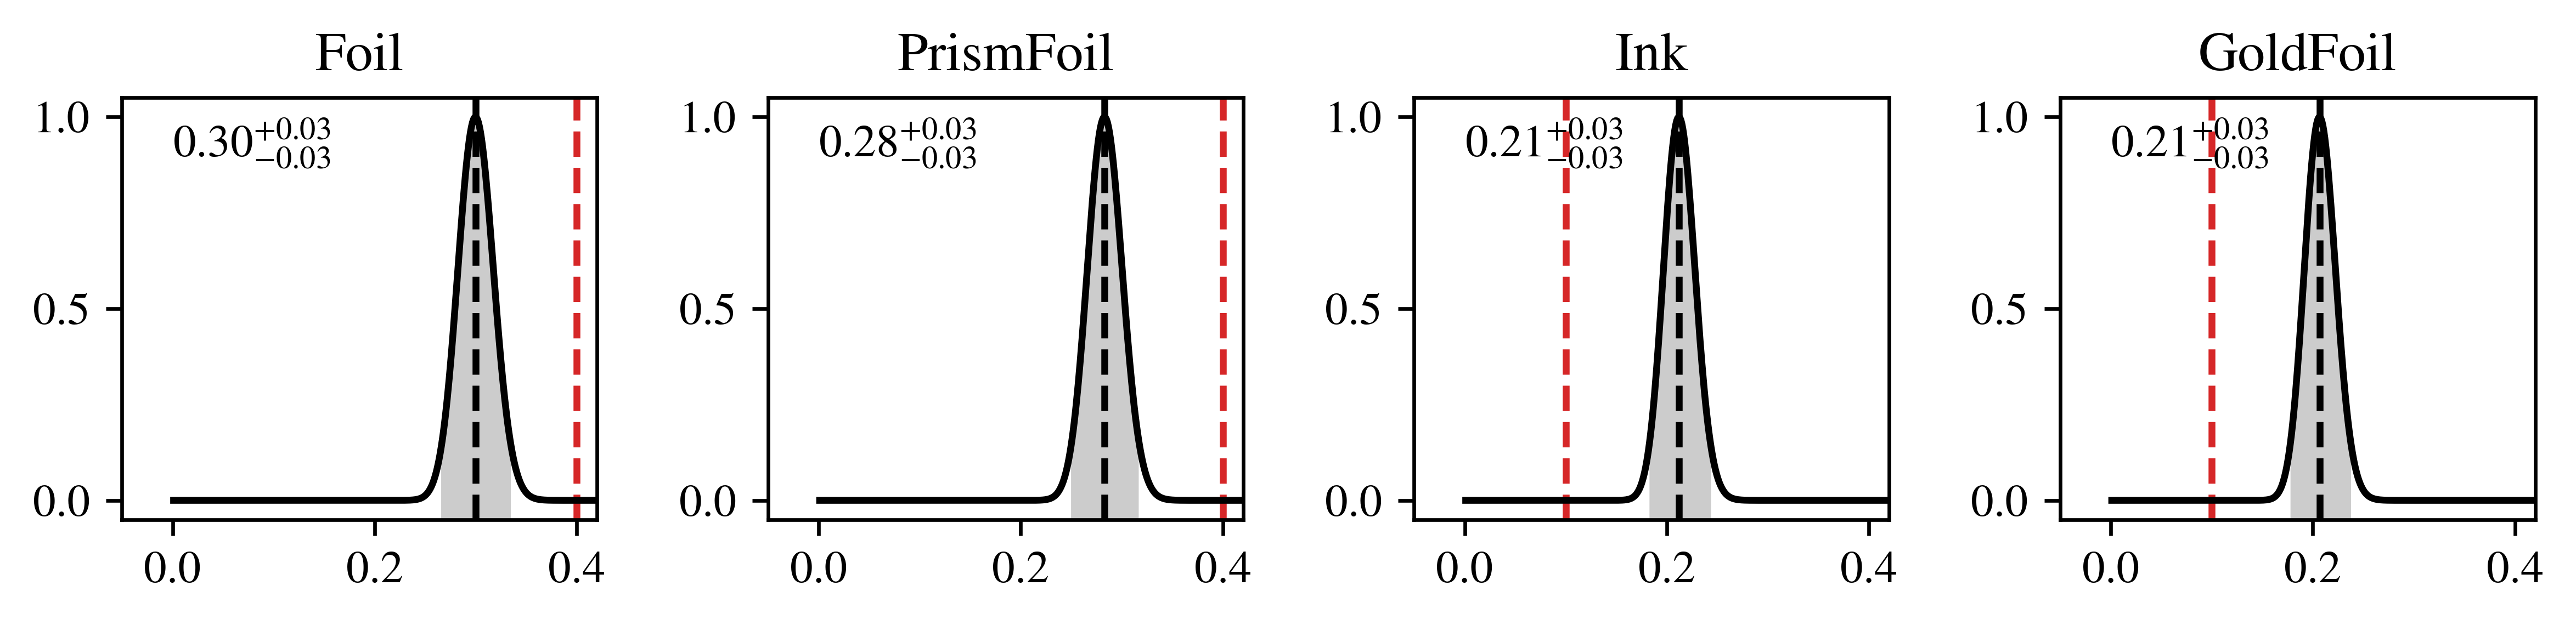

In [8]:
# back probs on fourth split
p_grid = np.linspace(0.001,0.999,1000)
colors = ['Foil', 'PrismFoil', 'Ink','GoldFoil']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.4,0.4,0.1,0.1]
all_cards = all_cards_master.copy()
n_cull = 4

for collection in collection_list:
    all_cards = collection.copy()
    for name in all_cards['name'].unique():
        subset = all_cards[all_cards['name']==name]
        n_splits = len(subset)
        # if we do not have enough splits to get to ink, go to next card
        if n_splits < 5:
            continue
        # first, compute ink
        subset, n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull = cull_splits(subset, n_cull=n_cull)

        n_poss_color = len(subset)
        counts = np.zeros(len(colors))

        n_gold_left = 4*8 - n_gold_cull
        n_ink_left = 4*8 - n_ink_cull
        n_foil_left = 4*8 - n_foil_cull
        n_prism_left = 4*8 - n_prism_cull
        n_left_list = [n_foil_left, n_prism_left, n_ink_left, n_gold_left]
        # this is known
        n_total_left = 4*4*8 - 4
        for sub in subset.iterrows():
            #loop over backs
            #print(sub)
            for i in range(len(colors)):
                if colors[i] == sub[1]['back']:
                    counts[i] += 1
        #print(name)
        for i in range(len(colors)):
            # print(name, colors[i], counts[i],n_poss_color)
            or_grid = (p_grid/n_left_list[i]) / ((1-p_grid)/(n_total_left - n_left_list[i]))
            likelihood = scipy.stats.nchypergeom_wallenius.pmf(counts[i], n_total_left, n_left_list[i], n_poss_color, or_grid)
            # likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
            posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
            priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i])
    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

Cull: 2, 4, 0, 0
Left: 30, 28, 32, 32
Elef: 30, 28, 32, 32
Tota: 122, 122
Foil: 1.0, 2, 30, 122, 6
PrismFoil: 0.0, 4, 28, 122, 6
Ink: 0.0, 0, 32, 122, 6
GoldFoil: 0.0, 0, 32, 122, 6
Cull: 2, 4, 0, 0
Left: 30, 28, 32, 32
Elef: 30, 28, 32, 32
Tota: 122, 122
Foil: 0.0, 2, 30, 122, 6
PrismFoil: 0.0, 4, 28, 122, 6
Ink: 0.0, 0, 32, 122, 6
GoldFoil: 1.0, 0, 32, 122, 6
Cull: 3, 3, 0, 0
Left: 29, 29, 32, 32
Elef: 29, 29, 32, 32
Tota: 122, 122
Foil: 1.0, 3, 29, 122, 6
PrismFoil: 0.0, 3, 29, 122, 6
Ink: 0.0, 0, 32, 122, 6
GoldFoil: 0.0, 0, 32, 122, 6
Cull: 3, 2, 1, 0
Left: 29, 30, 31, 32
Elef: 29, 30, 31, 32
Tota: 122, 122
Foil: 0.0, 3, 29, 122, 6
PrismFoil: 0.0, 2, 30, 122, 6
Ink: 0.0, 1, 31, 122, 6
GoldFoil: 1.0, 0, 32, 122, 6
Cull: 3, 1, 0, 2
Left: 29, 31, 32, 30
Elef: 29, 31, 32, 30
Tota: 122, 122
Foil: 0.0, 3, 29, 122, 6
PrismFoil: 0.0, 1, 31, 122, 6
Ink: 0.0, 0, 32, 122, 6
GoldFoil: 1.0, 2, 30, 122, 6
Cull: 5, 0, 1, 0
Left: 27, 32, 31, 32
Elef: 27, 32, 31, 32
Tota: 122, 122
Foil: 0.0, 5, 27

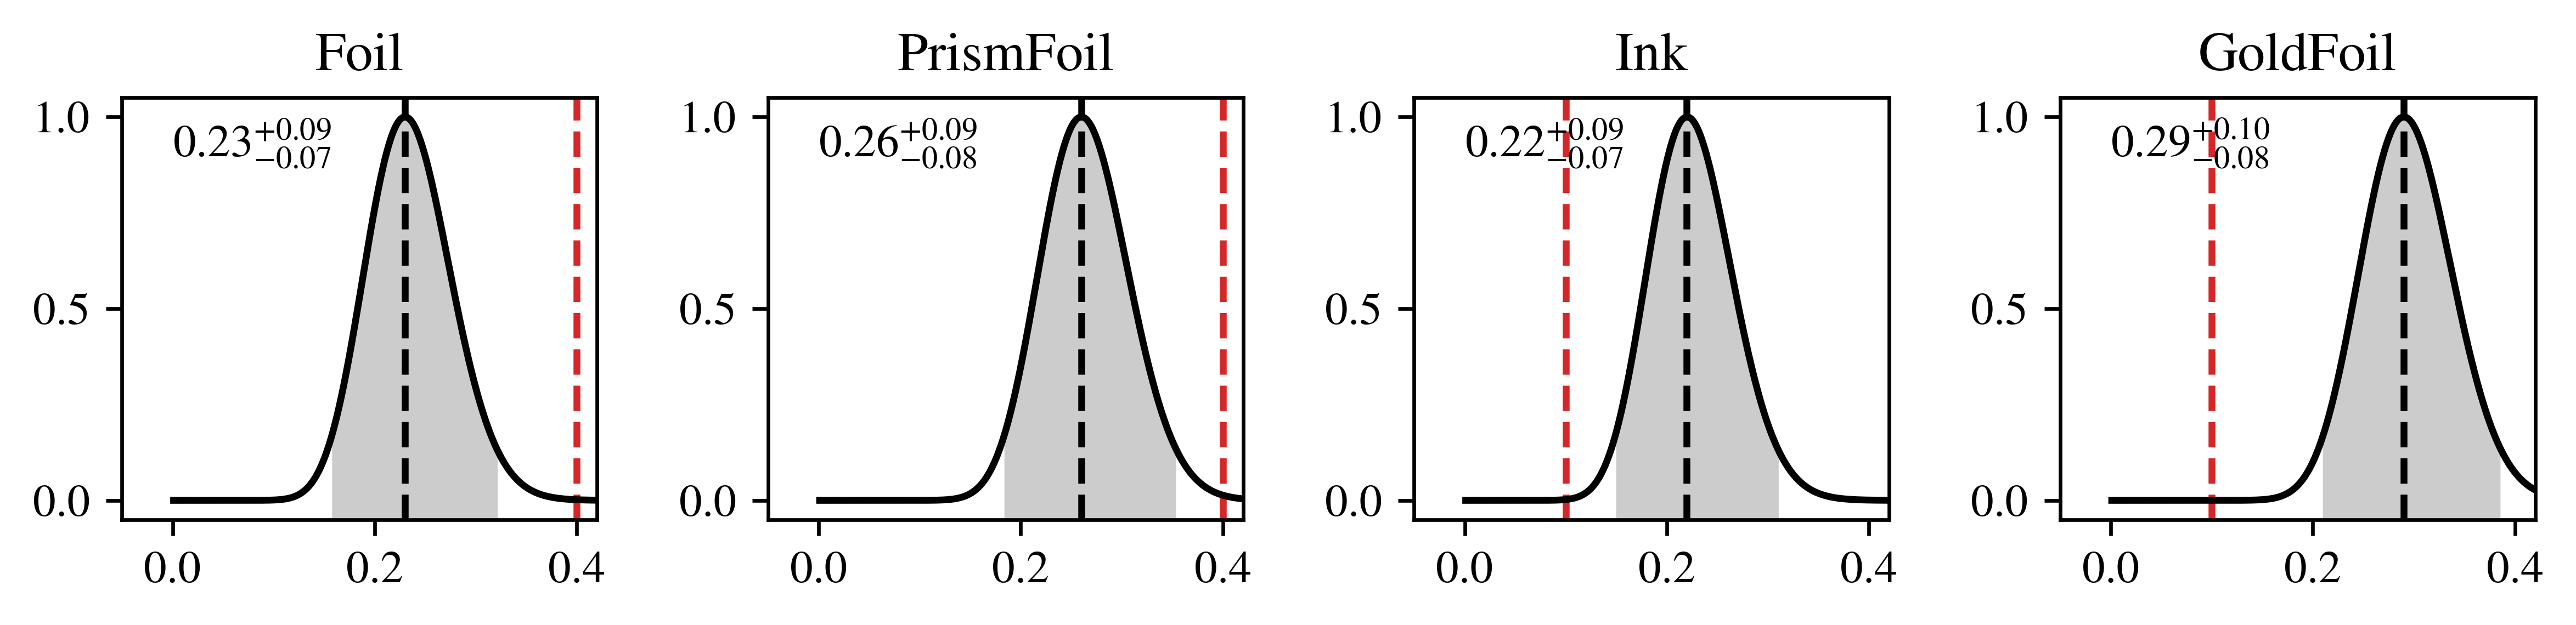

In [13]:
# back probs on fourth split
p_grid = np.linspace(0.001,0.999,1000)
colors = ['Foil', 'PrismFoil', 'Ink','GoldFoil']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.4,0.4,0.1,0.1]
all_cards = all_cards_master.copy()
split_to_test = 7
n_cull = split_to_test - 1

for collection in collection_list:
    all_cards = collection.copy()
    for name in all_cards['name'].unique():
        subset = all_cards[all_cards['name']==name]
        n_splits = len(subset)
        # if we do not have enough splits to get to ink, go to next card
        if n_splits < n_cull+1:
            continue
        # first, compute ink
        subset = subset.iloc[:n_cull+1]
        subset, n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull = cull_splits(subset, n_cull=n_cull)
        # only get the 
        subset = subset.iloc[0]
        n_poss_color = 1
        counts = np.zeros(len(colors))

        n_gold_left = 4*8 - n_gold_cull
        n_ink_left = 4*8 - n_ink_cull
        n_foil_left = 4*8 - n_foil_cull
        n_prism_left = 4*8 - n_prism_cull
        n_cull_list = [n_foil_cull, n_prism_cull, n_ink_cull, n_gold_cull]
        n_left_list = [n_foil_left, n_prism_left, n_ink_left, n_gold_left]
        # this is known
        n_total_left = 4*4*8 - n_foil_cull - n_prism_cull - n_ink_cull - n_gold_cull 
        print(f"Cull: {n_foil_cull}, {n_prism_cull}, {n_ink_cull}, {n_gold_cull}")
        print(f"Left: {n_foil_left}, {n_prism_left}, {n_ink_left}, {n_gold_left}")
        print(f"Elef: {4*8 - n_foil_cull}, {4*8 -n_prism_cull}, {4*8 -n_ink_cull}, {4*8 -n_gold_cull}")
        print(f"Tota: {n_total_left}, {4*4*8 - np.sum([n_foil_cull,n_prism_cull,n_ink_cull,n_gold_cull])}")
        for i in range(len(colors)):
            if colors[i] == subset['back']:
                counts[i] += 1
        #print(name)
        for i in range(len(colors)):
            print(f"{colors[i]}: {counts[i]}, {n_cull_list[i]}, {n_left_list[i]}, {n_total_left}, {np.sum(np.array(n_cull_list))}")
            # print(name, colors[i], counts[i],n_poss_color)
            or_grid = (p_grid/n_left_list[i]) / ((1-p_grid)/(n_total_left - n_left_list[i]))
            #print(counts[i], n_total_left, n_left_list[i], n_poss_color)
            likelihood = scipy.stats.nchypergeom_wallenius.pmf(counts[i], n_total_left, n_left_list[i], n_poss_color, or_grid)
            # likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
            posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
            priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i])
    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

In [6]:
posteriors = []
for i in range(4):
    posteriors.append(np.ones((4,10)))
print(posteriors[0][0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [73]:
# map cummulative product of posteriors
n_p_grid = 10000
p_grid = np.linspace(0.001,0.999,n_p_grid)
colors = ['Foil', 'PrismFoil', 'Ink','GoldFoil']
priors = [np.ones(n_p_grid)] * 4
nominals = [0.4,0.4,0.1,0.1]
#all_cards = all_cards_master.copy()
#n_cull = 10

#maxes = [[],[],[],[]]
#lows = [[],[],[],[]]
#highs = [[],[],[],[]]
split_nums = np.arange(5,10)

posteriors = []

posteriors = np.ones((len(colors),len(split_nums),n_p_grid))
#print(posteriors.shape)
#print(posteriors[0][0])

# raise StopExecution

for k in range(len(split_nums)):
    n_cull = split_nums[k]
    priors = [np.ones(n_p_grid)] * 4
    for collection in collection_list:
        all_cards = collection.copy()
        for name in all_cards['name'].unique():
            subset = all_cards[all_cards['name']==name]
            n_splits = len(subset)
            # if we do not have enough splits to get to ink, go to next card
            if n_splits < n_cull+1:
                continue
            # first, compute ink
            subset = subset.iloc[:n_cull+1]
            subset, n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull = cull_splits(subset, n_cull=n_cull)
            subset = subset.iloc[0]
            n_poss_color = 1
            counts = np.zeros(len(colors))

            n_gold_left = 4*8 - n_gold_cull
            n_ink_left = 4*8 - n_ink_cull
            n_foil_left = 4*8 - n_foil_cull
            n_prism_left = 4*8 - n_prism_cull
            n_left_list = [n_foil_left, n_prism_left, n_ink_left, n_gold_left]
            # this is known
            n_total_left = 4*4*8 - n_foil_cull - n_prism_cull - n_ink_cull - n_gold_cull 

            for i in range(len(colors)):
                if colors[i] == subset['back']:
                    counts[i] += 1
            #print(name)
            for i in range(len(colors)):
                # print(name, colors[i], counts[i],n_poss_color)
                or_grid = (p_grid/n_left_list[i]) / ((1-p_grid)/(n_total_left - n_left_list[i]))
                #print(counts[i], n_total_left, n_left_list[i], n_poss_color)
                likelihood = scipy.stats.nchypergeom_wallenius.pmf(counts[i], n_total_left, n_left_list[i], n_poss_color, or_grid)
                # likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
                posteriors[i][k] = likelihood * priors[i] / np.max(likelihood * priors[i])
                priors[i] = posteriors[i][k]
    #for i in range(len(colors)):
    #    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, posteriors[i], interval_width=0.95)
    #    maxes[i].append(p_grid[posteriors[i].argmax()])
    #    lows[i].append(low_bound)
    #    highs[i].append(high_bound)



In [57]:
posteriors.shape

(4, 5, 10000)

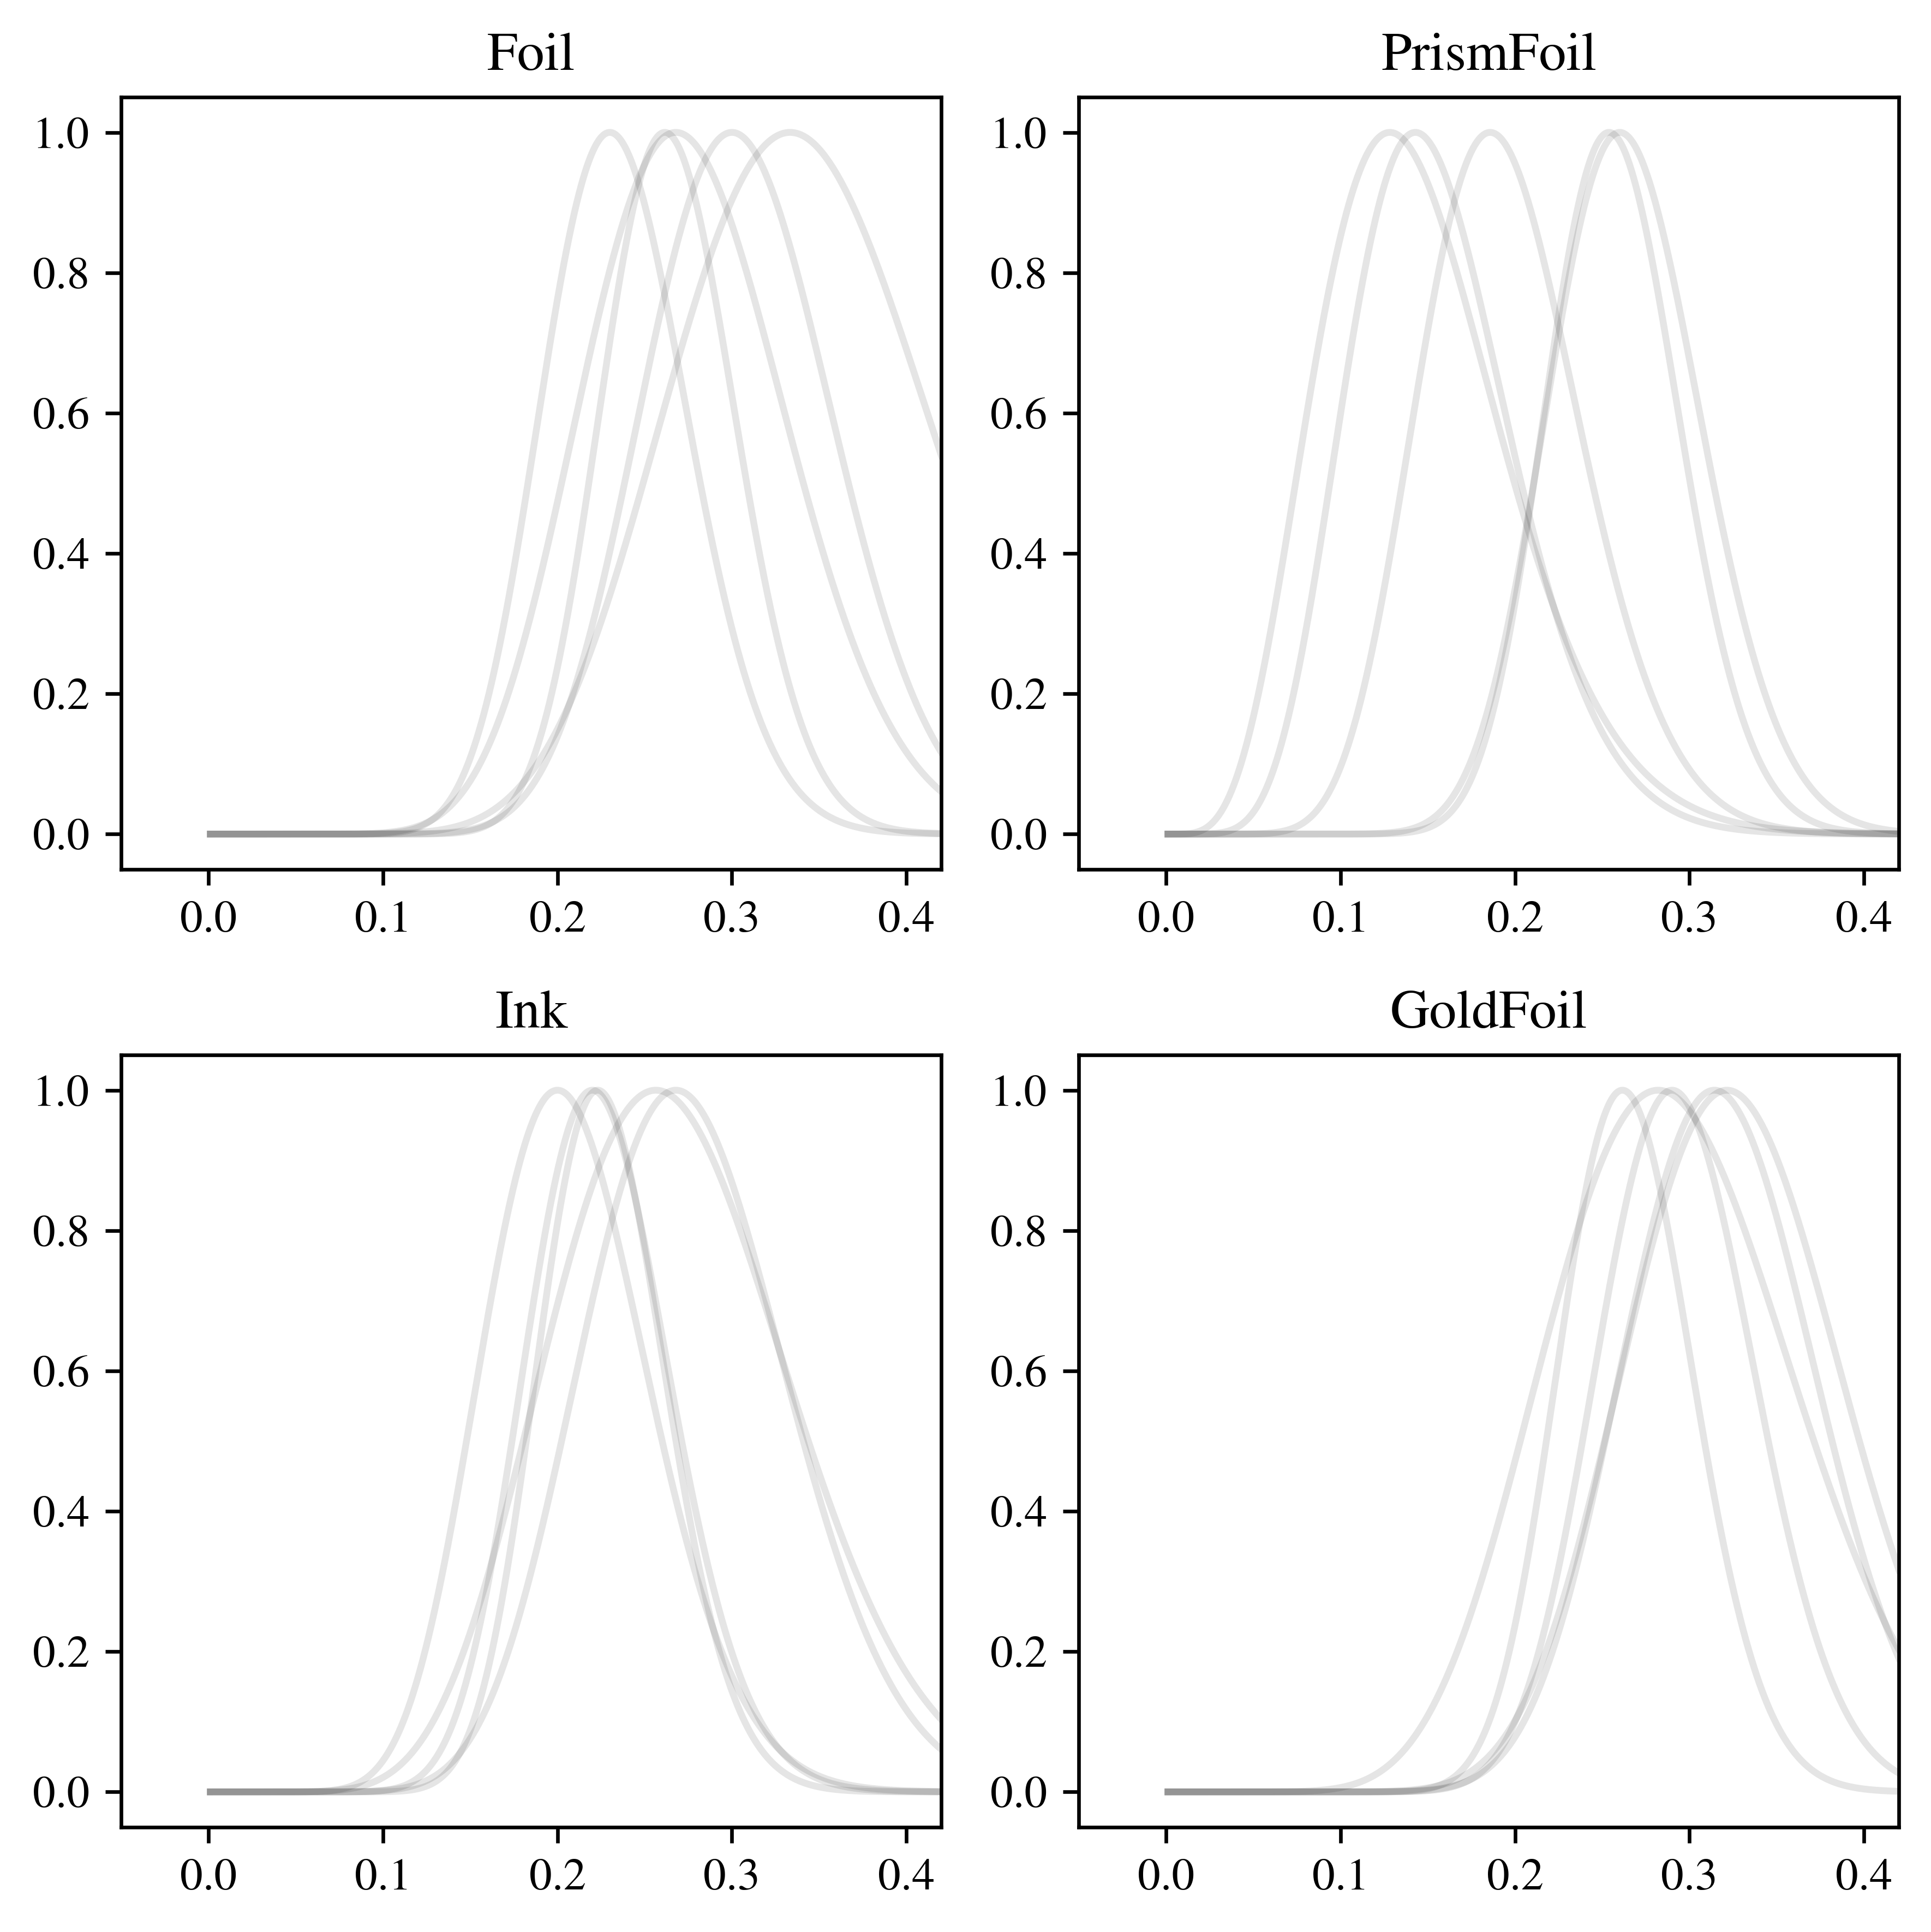

In [74]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(6,6))
plot_posteriors = posteriors.copy()

for i in range(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    temp_ax.set_title(titles[i])
    for k in range(len(split_nums)):
        temp_posterior = posteriors[i][k]
        temp_ax.plot(p_grid, temp_posterior,color='k',alpha=0.1)

    # ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    # ax[i].axvline(nominals[i],color='C3',linestyle='--')
    

    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    # low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    #fill_x = p_grid[low_arg:high_arg+1]
    #fill_y = temp_posterior[low_arg:high_arg+1]
    #temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    #temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

In [61]:
posteriors[0][0]

array([2.52697701e-070, 6.35676183e-069, 1.20713203e-067, ...,
       1.03462708e-248, 2.48062272e-252, 2.68869179e-256])

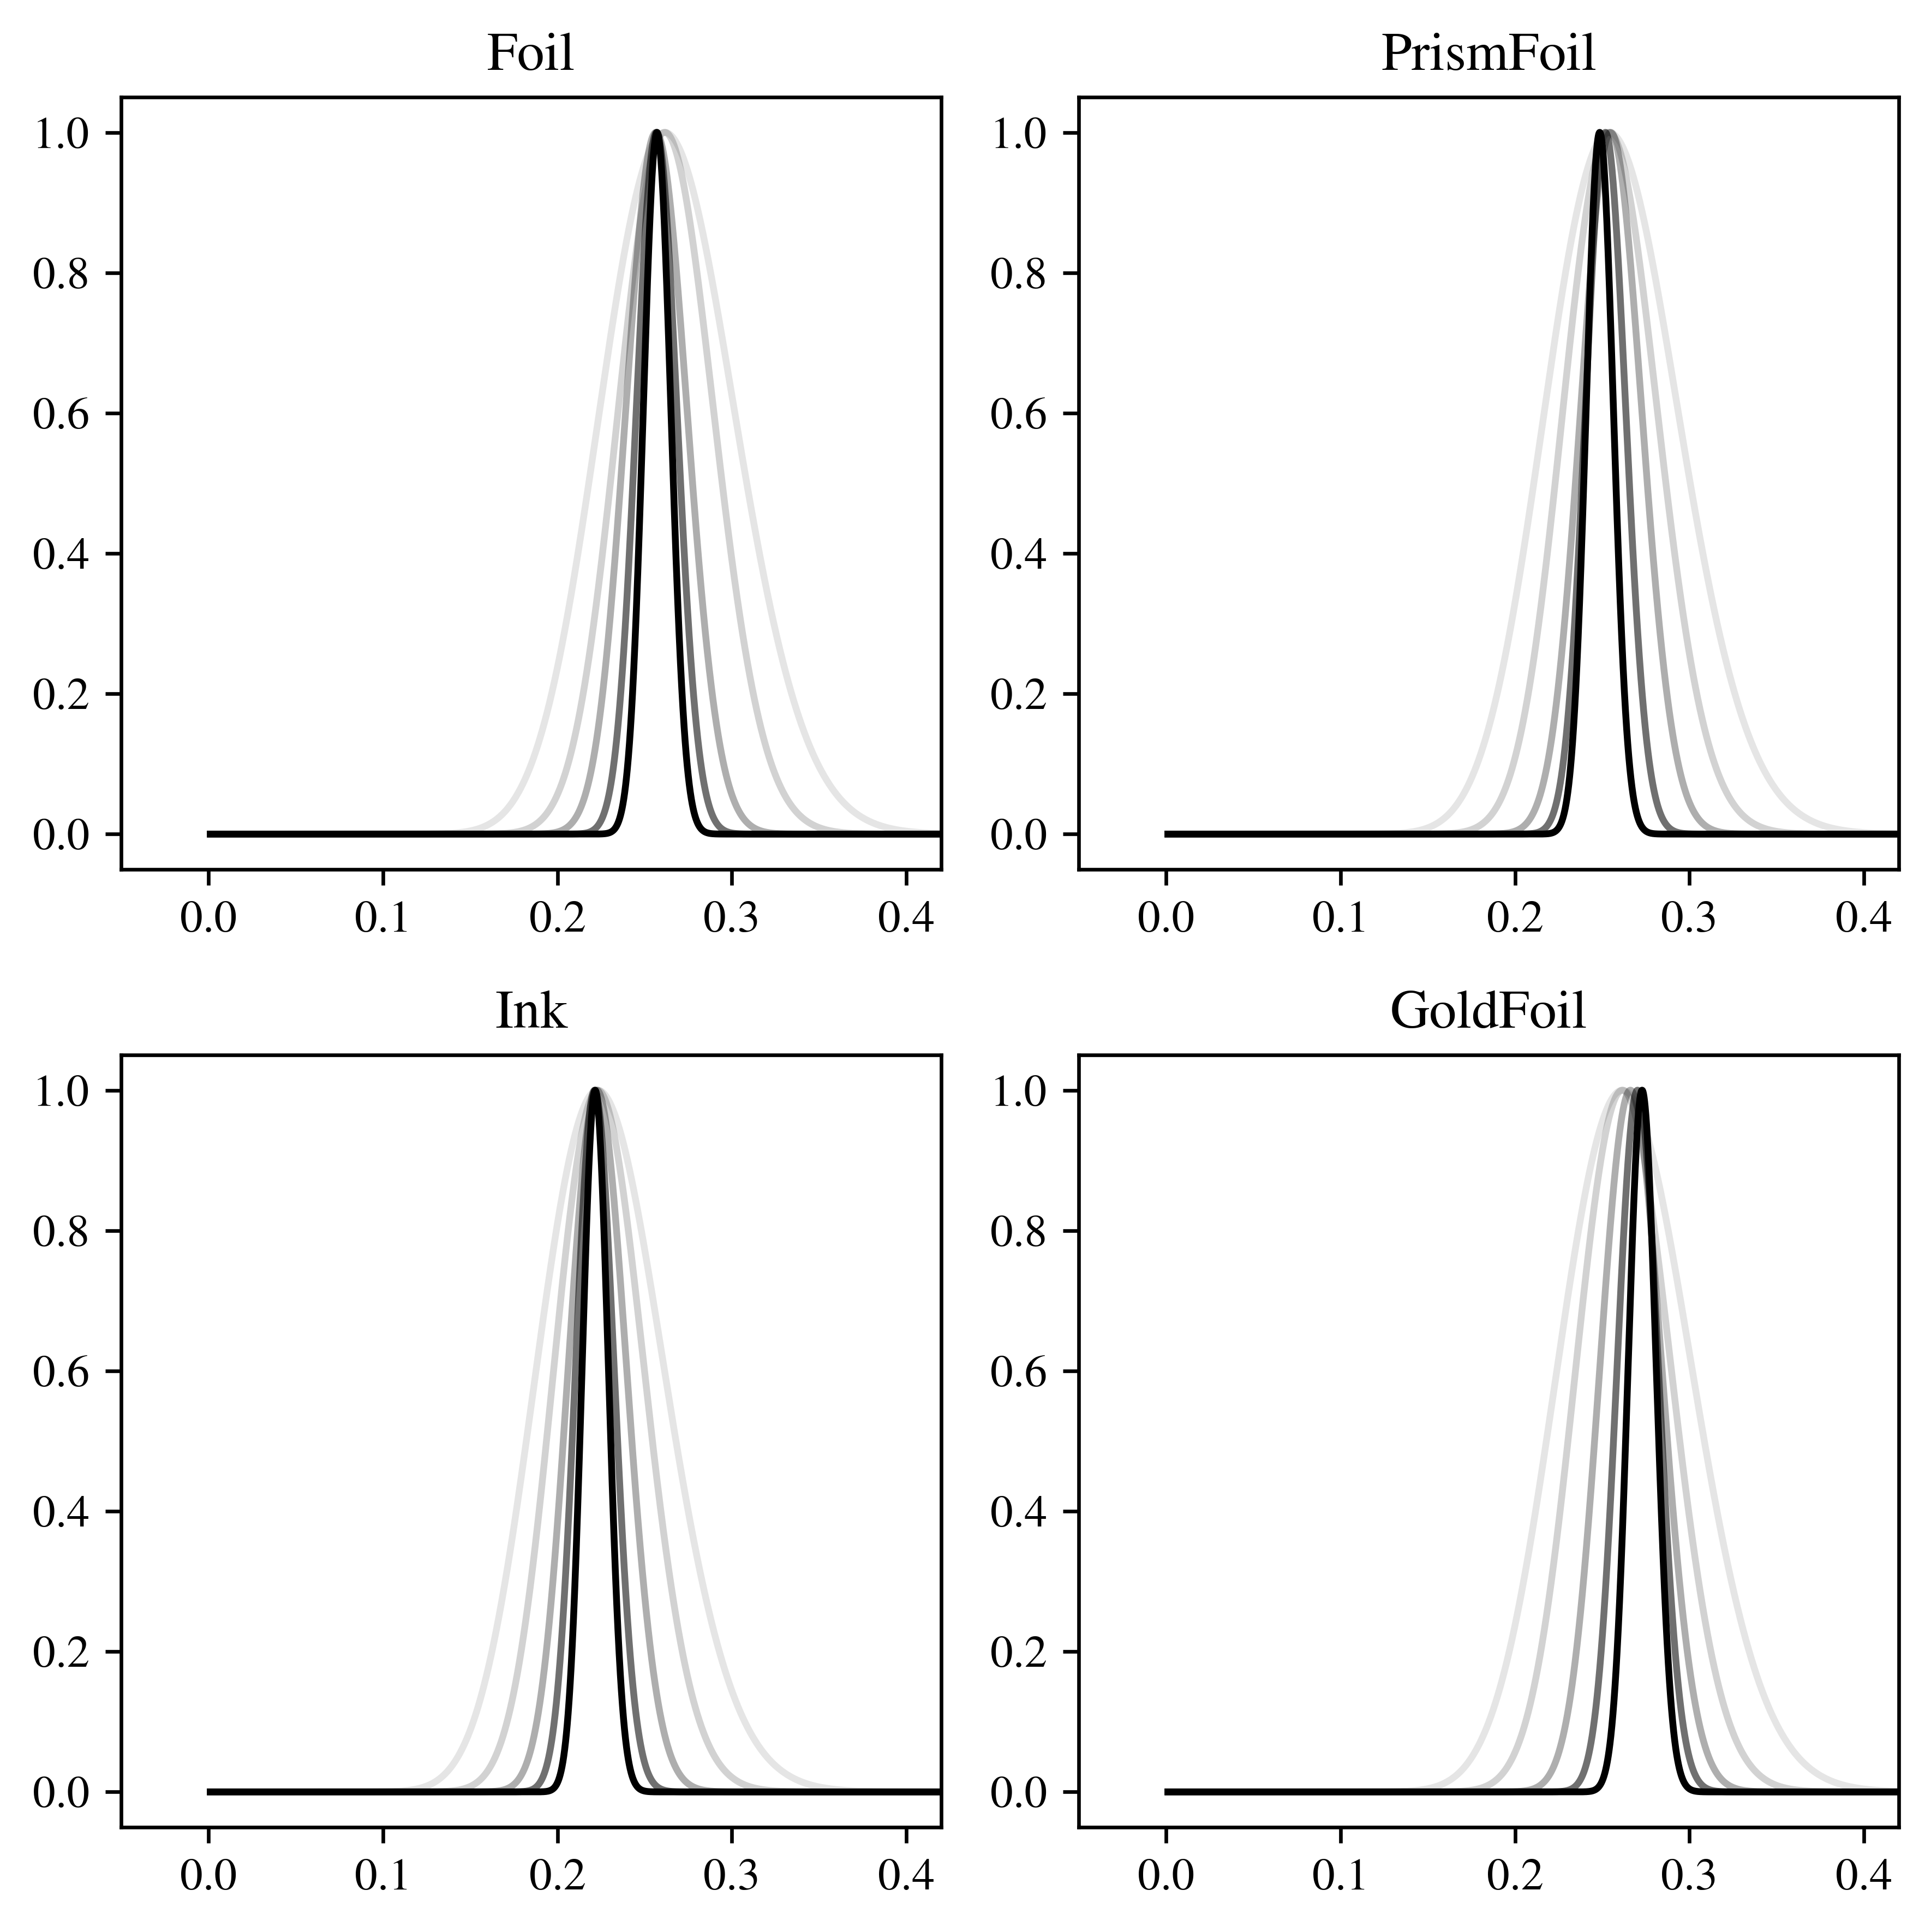

In [79]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(6,6))
alphas = np.logspace(-1,0,len(split_nums))
plot_posteriors = posteriors.copy()

# [0,1,2,3]
for i in range(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    temp_ax.set_title(titles[i])
    # [0,1,2,3,4,..., len(split_nums)-1]
    for k in range(len(split_nums)):
        temp_posterior = plot_posteriors[i][0]#np.ones(n_p_grid)
        # [0,1,2,3,..., k-1]
        for j in range(k):
            # first loop is [i][0]
            temp_posterior *= plot_posteriors[i][j]
        # temp_posterior = np.cumprod(posteriors[i][:k+1],axis=0)[0]#/np.max(np.cumprod(posteriors[i][:k+1],axis=1)[0])
        #print(alphas[k])
        temp_posterior /= np.max(temp_posterior)
        temp_ax.plot(p_grid, temp_posterior,color='k',alpha=alphas[k])

    # ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    # ax[i].axvline(nominals[i],color='C3',linestyle='--')
    

    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    # low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    #fill_x = p_grid[low_arg:high_arg+1]
    #fill_y = temp_posterior[low_arg:high_arg+1]
    #temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    #temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

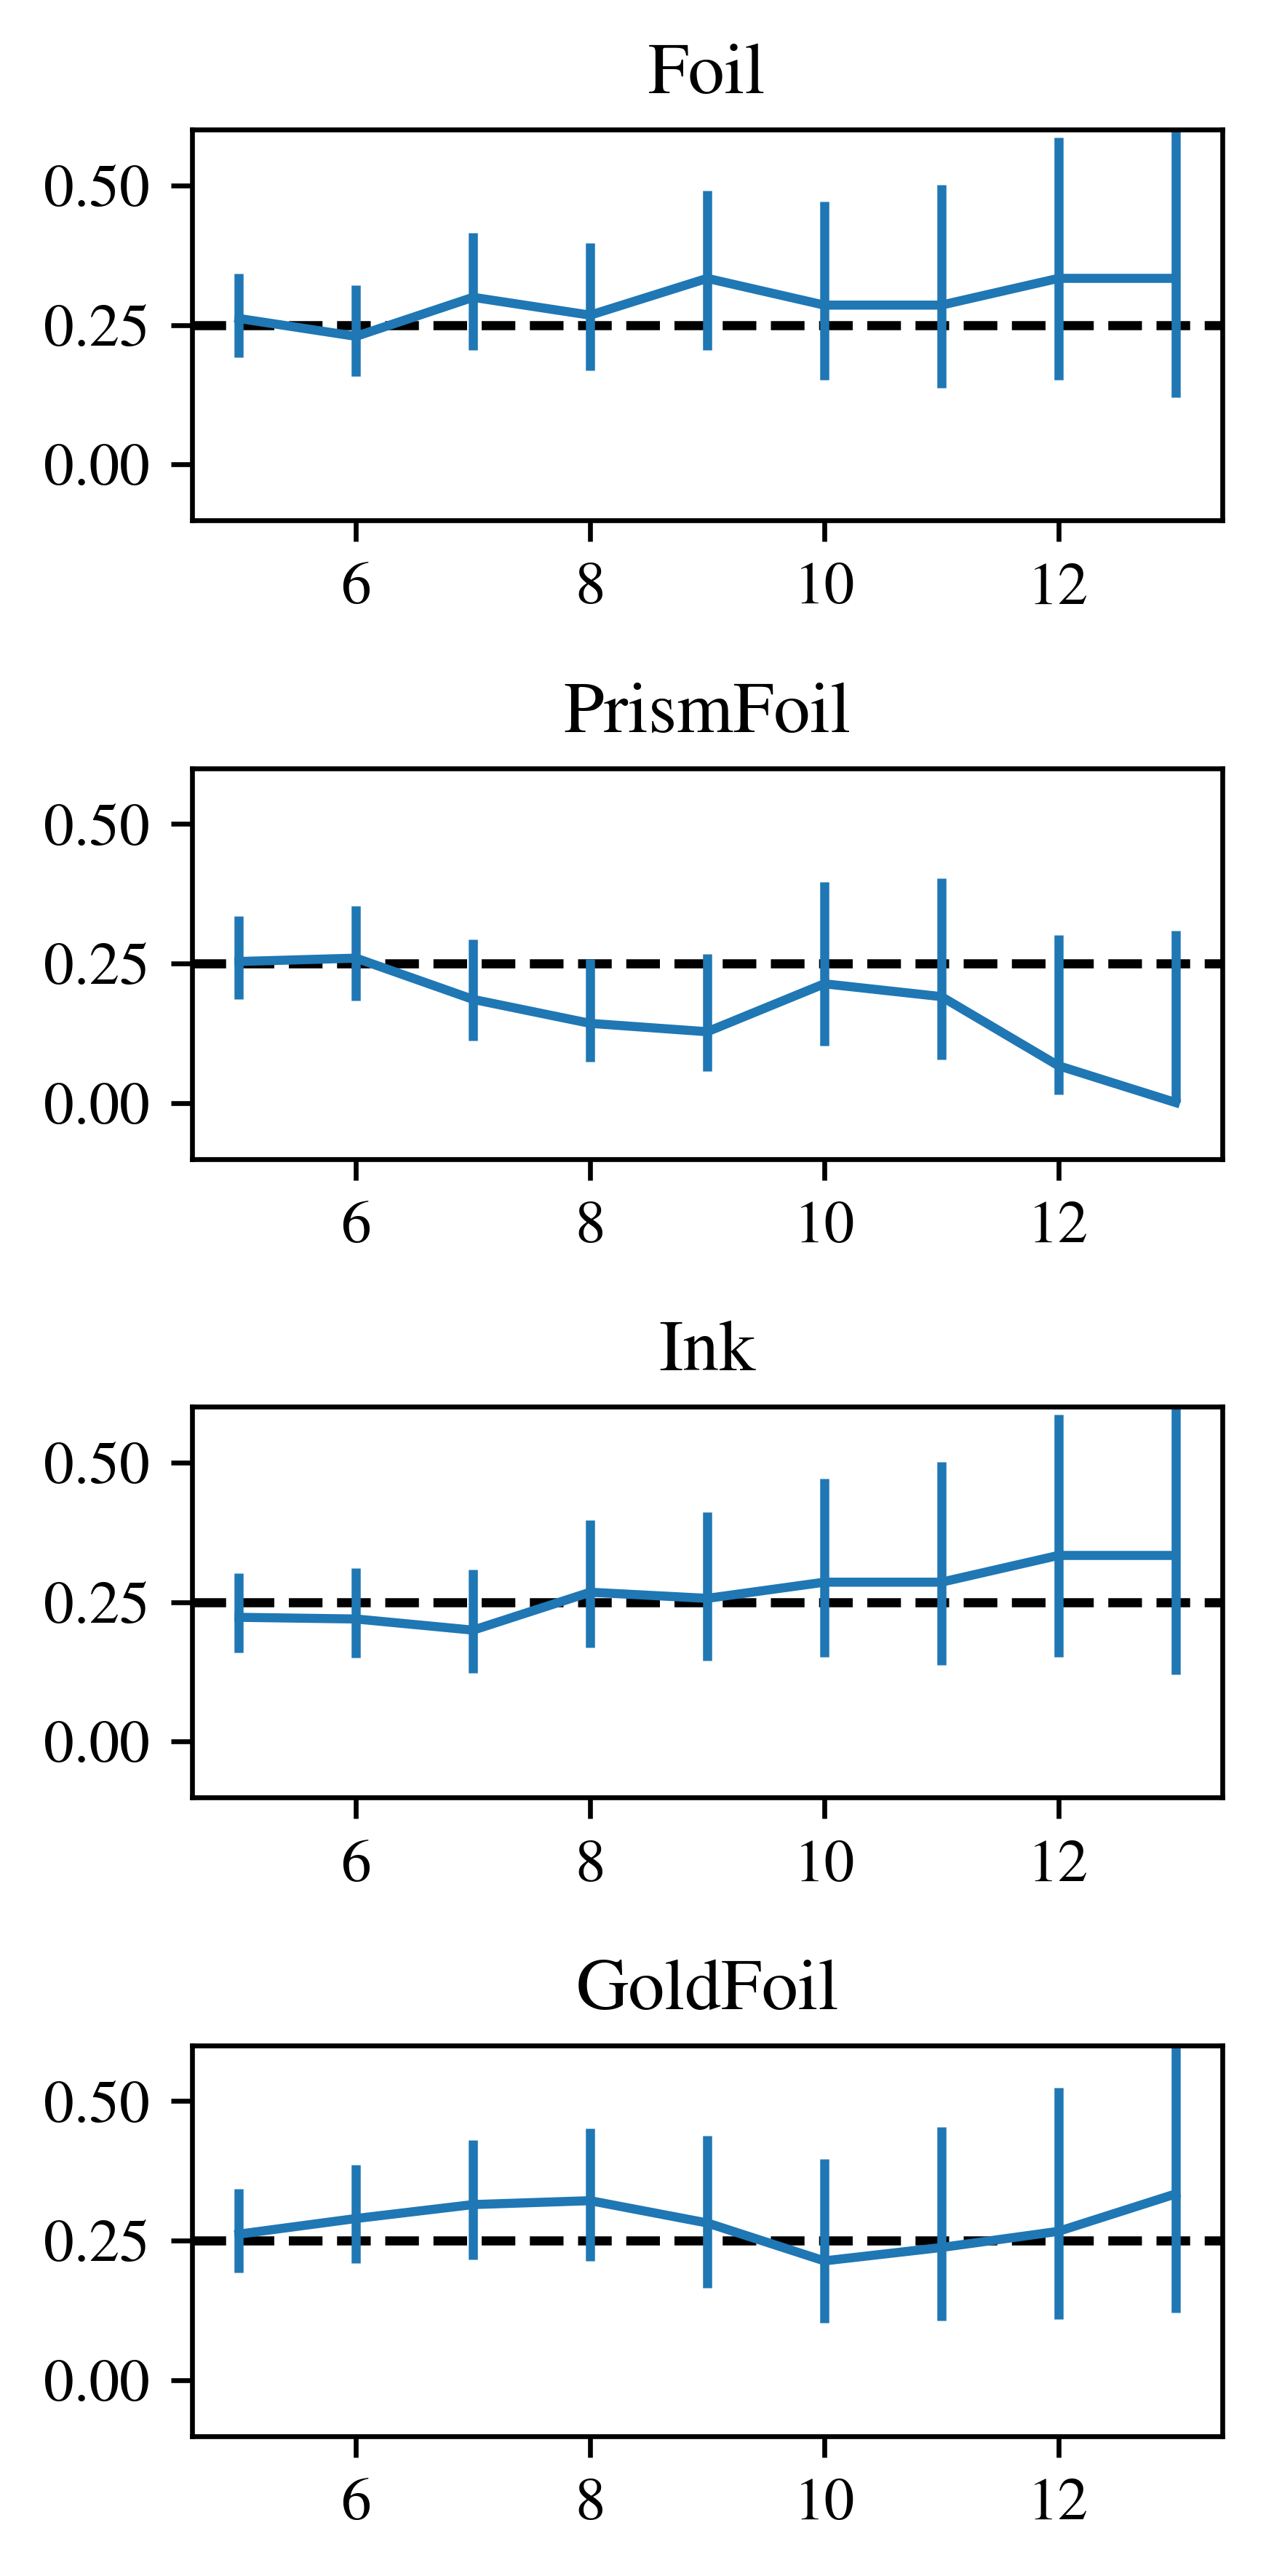

In [36]:
# back probs on fourth split
p_grid = np.linspace(0.001,0.999,1000)
colors = ['Foil', 'PrismFoil', 'Ink','GoldFoil']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.4,0.4,0.1,0.1]
all_cards = all_cards_master.copy()
#n_cull = 10

maxes = [[],[],[],[]]
lows = [[],[],[],[]]
highs = [[],[],[],[]]
split_nums = np.arange(5,14)

for n_cull in split_nums:
    priors = [np.ones(1000)] * 4
    posteriors = [np.ones(1000)] * 4
    for collection in collection_list:
        all_cards = collection.copy()
        for name in all_cards['name'].unique():
            subset = all_cards[all_cards['name']==name]
            n_splits = len(subset)
            # if we do not have enough splits to get to ink, go to next card
            if n_splits < n_cull+1:
                continue
            # first, compute ink
            subset = subset.iloc[:n_cull+1]
            subset, n_ink_cull, n_gold_cull, n_foil_cull, n_prism_cull = cull_splits(subset, n_cull=n_cull)
            subset = subset.iloc[0]
            n_poss_color = 1
            counts = np.zeros(len(colors))

            n_gold_left = 4*8 - n_gold_cull
            n_ink_left = 4*8 - n_ink_cull
            n_foil_left = 4*8 - n_foil_cull
            n_prism_left = 4*8 - n_prism_cull
            n_left_list = [n_foil_left, n_prism_left, n_ink_left, n_gold_left]
            # this is known
            n_total_left = 4*4*8 - n_foil_cull - n_prism_cull - n_ink_cull - n_gold_cull 

            for i in range(len(colors)):
                if colors[i] == subset['back']:
                    counts[i] += 1
            #print(name)
            for i in range(len(colors)):
                # print(name, colors[i], counts[i],n_poss_color)
                or_grid = (p_grid/n_left_list[i]) / ((1-p_grid)/(n_total_left - n_left_list[i]))
                #print(counts[i], n_total_left, n_left_list[i], n_poss_color)
                likelihood = scipy.stats.nchypergeom_wallenius.pmf(counts[i], n_total_left, n_left_list[i], n_poss_color, or_grid)
                # likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
                posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
                priors[i] = posteriors[i]
    for i in range(len(colors)):
        low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, posteriors[i], interval_width=0.95)
        maxes[i].append(p_grid[posteriors[i].argmax()])
        lows[i].append(low_bound)
        highs[i].append(high_bound)

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(3,6))

for i in range(len(colors)):
    low_err = np.maximum(np.array(lows[i]),np.zeros(len(lows[i])))
    errors = np.array(list(zip(low_err, highs[i]))).T
    ax[i].set_title(colors[i])
    ax[i].axhline(0.25,color='k',linestyle='--')
    ax[i].errorbar(np.array(split_nums), maxes[i], yerr=errors,label=colors[i])

    ax[i].set_ylim(.25-.35,.25+.35)

fig.tight_layout()

In [10]:
# background probs on or after fifth split
p_grid = np.linspace(0,1,1000)
colors = ['Foil', 'PrismFoil', 'Ink', 'GoldFoil']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.4,0.4,0.1,0.1]
all_cards = all_cards_master.copy()

for collection in collection_list:
    all_cards = collection.copy()
    for name in all_cards['name'].unique():
        subset = all_cards[all_cards['name']==name]
        n_splits = len(subset)
        n_cull = 4
        # if we do not have enough splits to get to gold, go to next card
        # we will only look at probas post gold being possible
        if n_splits < n_cull+1:
            continue
        # There was a card that was throwing an issue, can't cull more than available.
        # this means there is a card that had an filter list that was too large for some reason
        
        subset = cull_splits(subset,n_cull=n_cull)

        # first, compute ink
        n_poss_color = len(subset)
        counts = np.zeros(len(colors))

        for sub in subset.iterrows():
            #loop over backs
            #print(sub)
            for i in range(len(colors)):
                if colors[i] == sub[1]['back']:
                    counts[i] += 1
                    #print(colors[i],sub[1]['back'],counts[i])
        #print(name)
        for i in range(len(colors)):
            # print(name, colors[i], counts[i],n_poss_color)
            likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
            posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
            priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3',linestyle='--')
    temp_ax.plot(p_grid, temp_posterior,color='k')
    temp_ax.set_title(titles[i])
    # temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

AttributeError: 'tuple' object has no attribute 'iterrows'

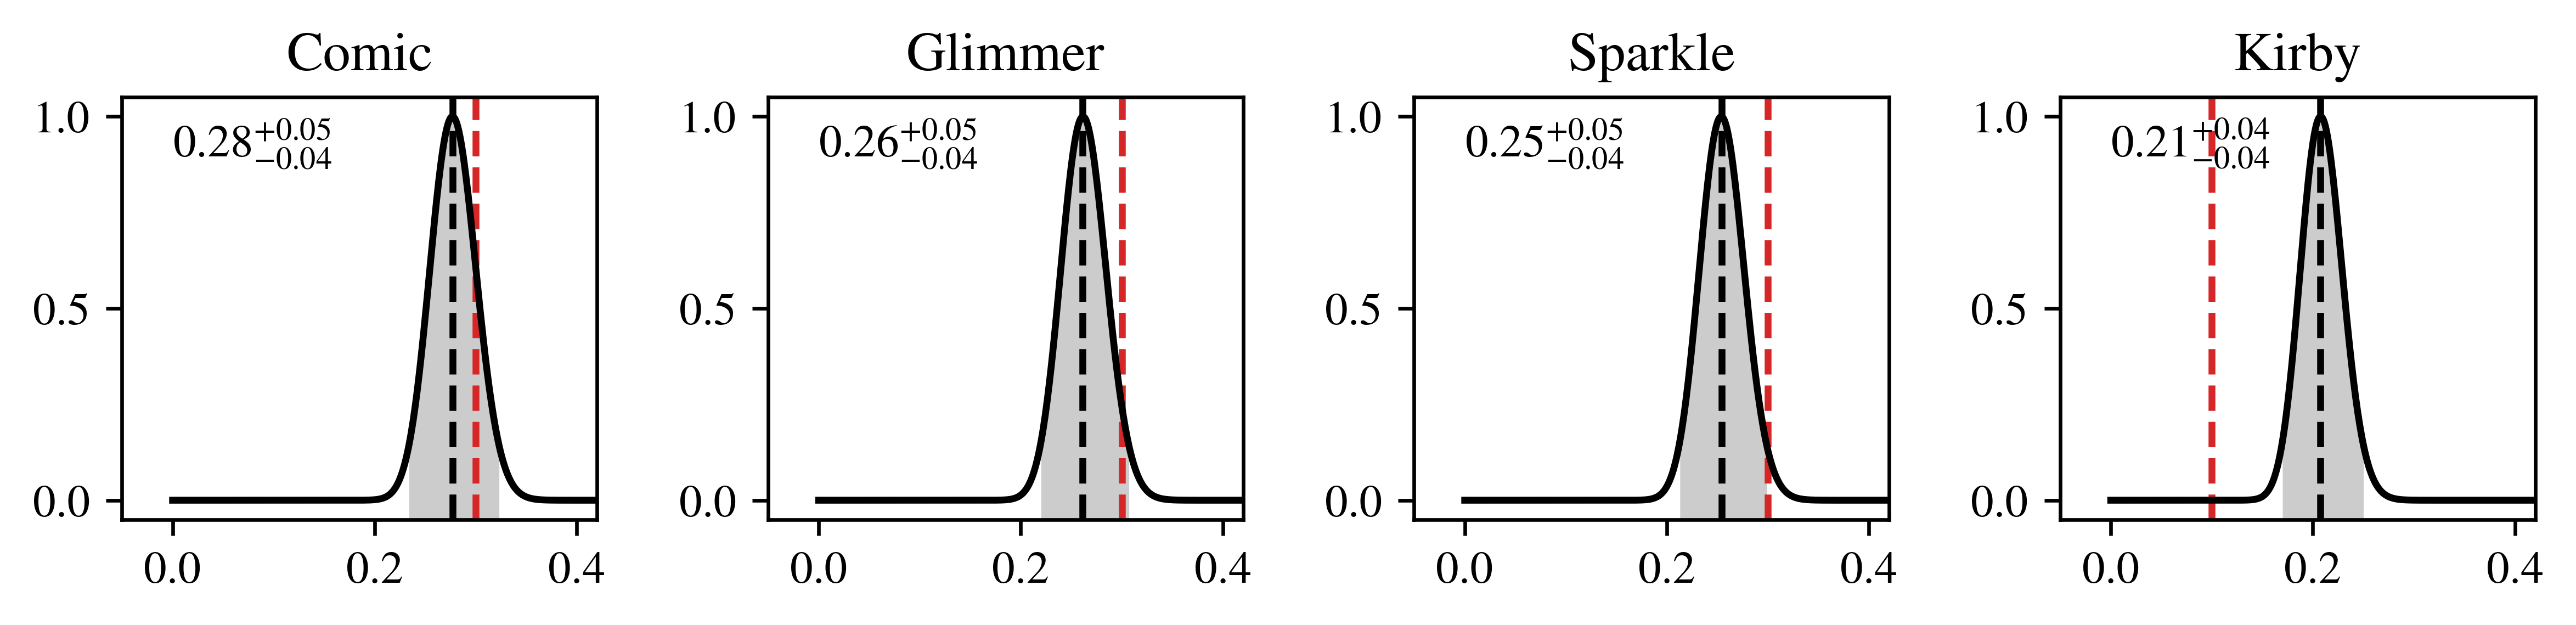

In [ ]:
# effect probs after sixth split
p_grid = np.linspace(0,1,1000)
colors = ['Comic', 'Glimmer', 'Sparkle', 'Kirby']
priors = [np.ones(1000)] * 4
posteriors = [np.ones(1000)] * 4
nominals = [0.3, 0.3, 0.3, 0.1]
all_cards = all_cards_master.copy()

for collection in collection_list:
    all_cards = collection.copy()
    for name in all_cards['name'].unique():
        subset = all_cards[all_cards['name']==name]
        n_splits = len(subset)
        n_cull = 5
        # if we do not have enough splits to get to gold, go to next card
        # we will only look at probas post gold being possible
        if n_splits < n_cull+1:
            continue
        # There was a card that was throwing an issue, can't cull more than available.
        # this means there is a card that had an filter list that was too large for some reason
        random_cull = False
        if random_cull:
            try:
                subset = random_cull_splits(subset,n_cull=n_cull)
            except:
                continue
        else: 
            subset = cull_splits(subset, n_cull=n_cull)
        # first, compute ink
        n_poss_color = len(subset)
        counts = np.zeros(len(colors))

        for sub in subset.iterrows():
            #loop over backs
            #print(sub)
            for i in range(len(colors)):
                if colors[i] in sub[1]['effect']:
                    counts[i] += 1
                    #print(colors[i],sub[1]['back'],counts[i])
        #print(name)
        for i in range(len(colors)):
            # print(name, colors[i], counts[i],n_poss_color)
            likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
            posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
            priors[i] = posteriors[i]

        
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 2))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    ax[i].axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    ax[i].axvline(nominals[i],color='C3', linestyle='--')
    temp_ax.plot(p_grid, temp_posterior, color='k')
    temp_ax.set_title(titles[i])
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x-text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='left')

fig.tight_layout()

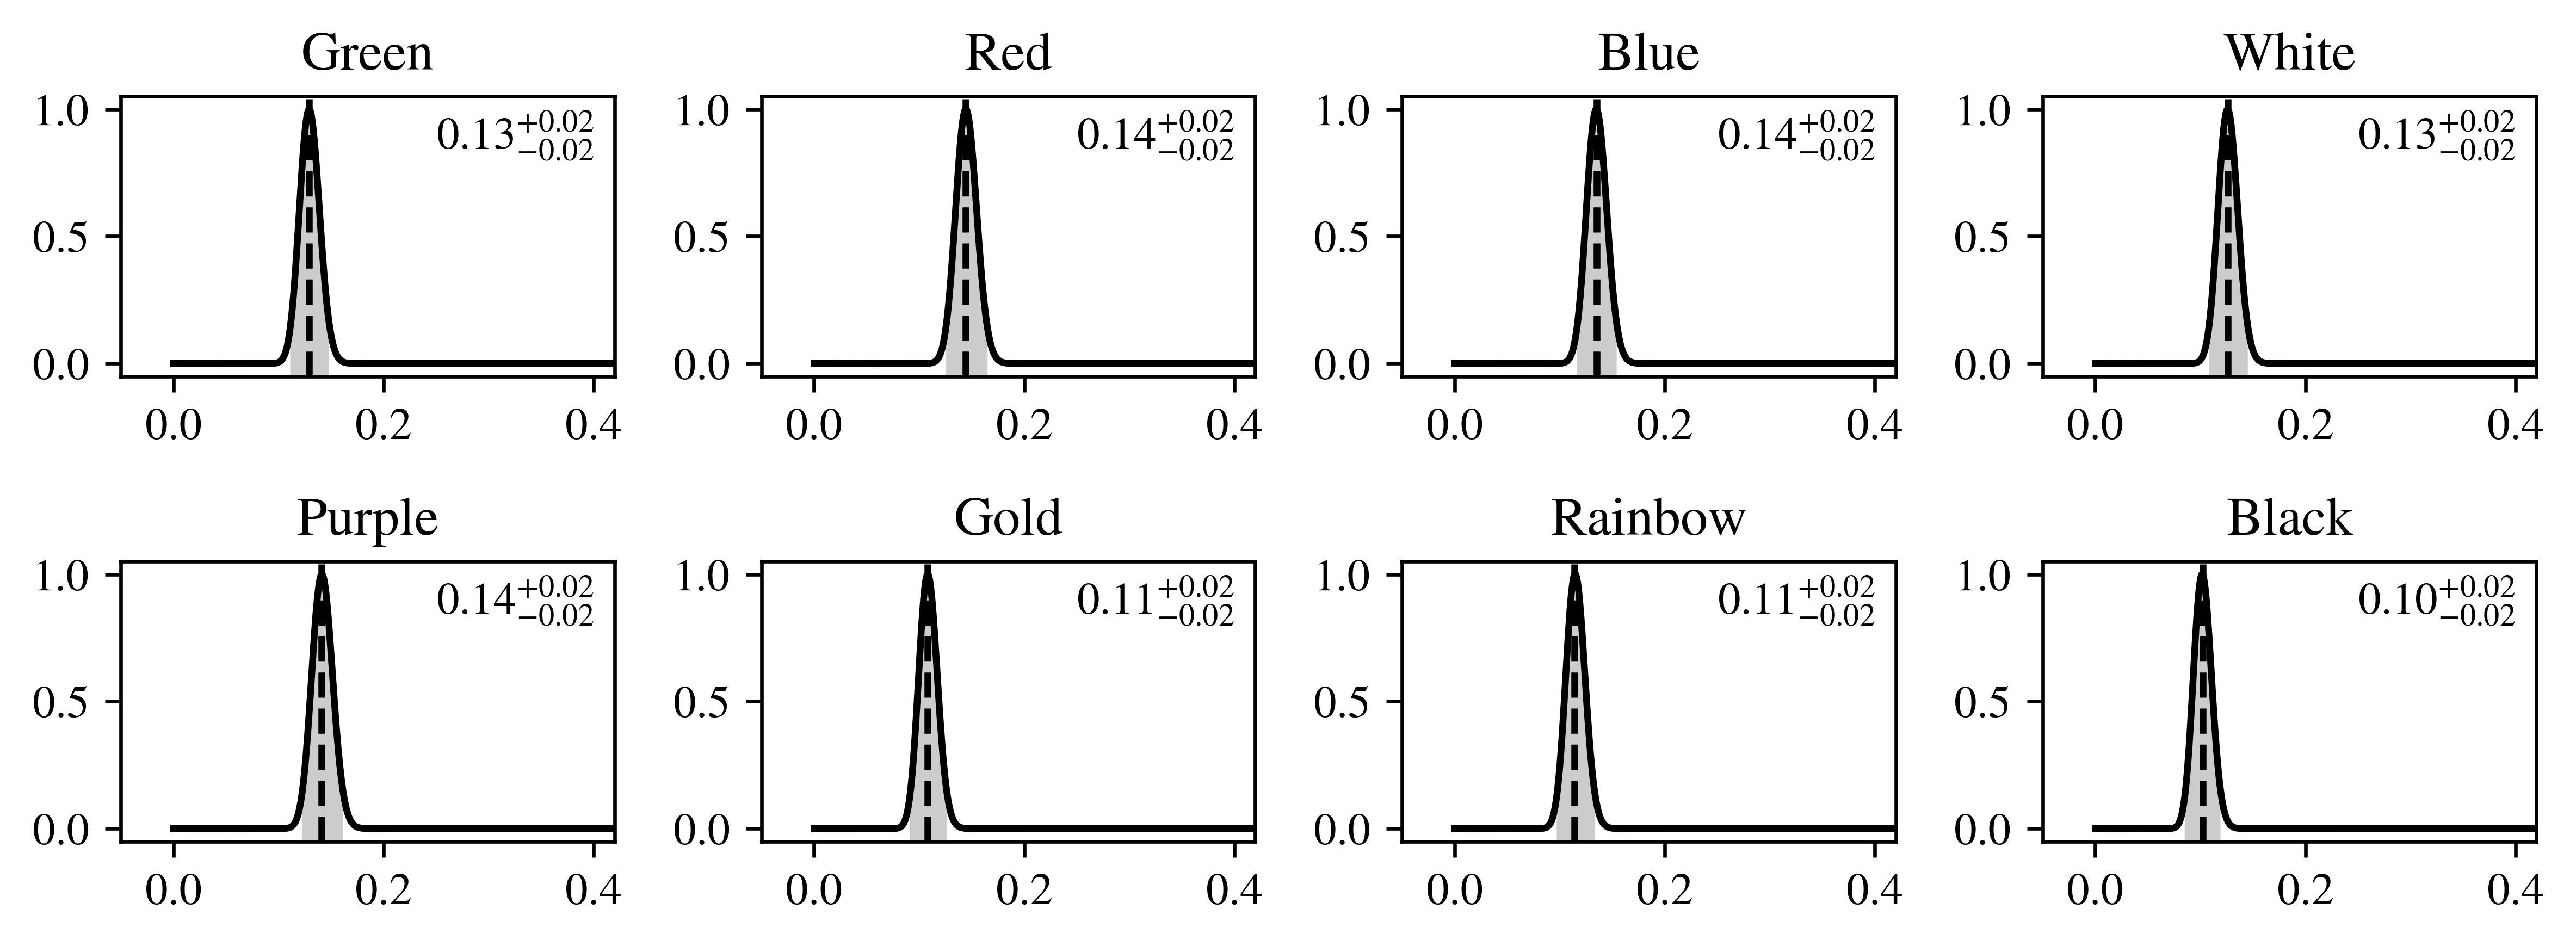

In [24]:
# color probs on or after second split
p_grid = np.linspace(0,1,1000)
colors = ['Green','Red', 'Blue', 'White', 'Purple', 'Gold', 'Rainbow', 'Black']
priors = [np.ones(1000)] * 8
posteriors = [np.ones(1000)] * 8
all_cards = all_cards_master.copy()

for collection in collection_list:
    all_cards = collection.copy()
    for name in all_cards['name'].unique():
        subset = all_cards[all_cards['name']==name]
        n_splits = len(subset)
        n_cull = 1
        # if we do not have enough splits to get to ink, go to next card
        if n_splits < n_cull+1:
            continue

        subset = cull_splits(subset, n_cull=n_cull)
        # first, compute ink
        n_poss_color = n_splits - n_cull
        counts = np.zeros(len(colors))

        for sub in subset.iterrows():
            #print(sub[1]['effect'])
            #filter nan
            if sub[1]['effect'] == sub[1]['effect']:
                #loop over colors
                for i in range(len(colors)):
                    if colors[i] in sub[1]['effect']:
                        counts[i] += 1

        for i in range(len(colors)):
            likelihood = scipy.stats.binom.pmf(counts[i],n_poss_color,p_grid)
            posteriors[i] = likelihood * priors[i] / np.max(likelihood * priors[i])
            priors[i] = posteriors[i]

    
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 3))
text_x = 0.4
text_y = 1
titles = colors

for i in np.arange(len(colors)):
    temp_ax = ax.flatten()[i]
    temp_posterior = posteriors[i]
    temp_ax.set_xlim(-0.05,text_x+text_x*0.05)
    temp_ax.set_ylim(-0.05,1.05)
    temp_ax.plot(p_grid, temp_posterior, color='k')
    temp_ax.set_title(titles[i])
    temp_ax.axvline(p_grid[temp_posterior.argmax()],color='k',linestyle='--')
    low_arg, high_arg, pos_low, pos_high, low_bound, high_bound = estimate_uncertainty(p_grid, temp_posterior, interval_width=0.95)
    fill_x = p_grid[low_arg:high_arg+1]
    fill_y = temp_posterior[low_arg:high_arg+1]
    temp_ax.fill_between(fill_x,fill_y,-1*np.ones(len(fill_x)),color='k',alpha=0.2,edgecolor=None)
    temp_ax.text(text_x,text_y,f'${p_grid[temp_posterior.argmax()]:.2f}^{{+{high_bound:0.2f}}}_{{-{low_bound:0.2f}}}$',verticalalignment='top',horizontalalignment='right')

fig.tight_layout()